# Import Library

In [698]:
# IMPORT LIBRARY

import pandas as pd
from pathlib import Path
import numpy as np
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import pairwise_distances
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Function Library

In [699]:
# FUNCTION LIBRARY

# Function to normalize name differences and convert to "First_Last"
def normalize_name(name):
    # Remove suffixes (CHECK TO MAKE SURE HIT EVERYTHING)
    name = name.replace(' Jr.', '')
    name = name.replace(' Sr.', '')
    name = name.replace(' V', '')
    name = name.replace(' IV', '')
    name = name.replace(' III', '')
    name = name.replace(' II', '')
    name = name.replace(' I', '')
    name = name.replace(' Iii', '')
    name = name.replace(' Ii', '')
    name = name.replace(' Iv', '')

    # Remove periods
    name = name.replace('.', '')

    # Remove apostrophes
    name = name.replace("'", '')

    # Replace spaces with underscore
    name = name.replace(' ', '_')

    # Convert to uppercase and capitalize first letter
    name_parts = name.split('_')
    name = '_'.join(part.capitalize() for part in name_parts)

    return name

# Function to apply the cluster labels
def label_clusters(row):
    # Assign "low-peformer" label to athletes in cluster 0
    if row['cluster'] == 0:
        return 'average_performer'
    
    # Assign "average-peformer" label to athletes in cluster 1
    elif row['cluster'] == 1:
        return 'high_performer'
    
    # Assign "high-peformer" label to athletes in cluster 2
    elif row['cluster'] == 2:
        return 'low_performer'

# Function to creat the RFECV plots
def plot_rfecv_results(rfecv, X, title):
    # initialize the RFECV variables
    total_features = X.shape[1]
    step_size = rfecv.step
    num_features_tested = len(rfecv.cv_results_['mean_test_score'])
    
    # Adjust feature_steps calculation
    feature_steps = list(range(total_features, 0, -step_size))
    
    # Correct the length of feature_steps
    if len(feature_steps) > num_features_tested:
        feature_steps = feature_steps[:num_features_tested]  
    
    # Handle cases where step size does not align
    elif len(feature_steps) < num_features_tested:
        feature_steps.append(feature_steps[-1] - (step_size * (num_features_tested - len(feature_steps))))

    # Sort RFECV features
    feature_steps = sorted(set(feature_steps))  # Ensure uniqueness and correct order

    # Initialize the plot, axis, and title info
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.set_title(title, fontweight= 'bold', fontsize= 15)
    ax.set_xlabel("Number of features selected")
    ax.set_ylabel("Cross-validation score (accuracy)")

    # Plot the data
    scores = rfecv.cv_results_['mean_test_score']
    ax.plot(feature_steps, scores, marker='o')
    ax.set_xticks(feature_steps)
    ax.grid(True)
    plt.show()


def standardized_figure_title(fig, title, underline_diff= 0.03, fontsize= 20):
    # Assign subtitle to figure
    fig_title_text = fig.suptitle(
        t= title.upper(), 
        fontweight= 'bold', 
        fontsize= fontsize, 
        y= 1.005
    )

    # Calculate the position for the underline based on the title position
    fig_title_position = fig_title_text.get_position()
    underline_height = fig_title_position[1] - underline_diff

    # Add a underline across the entire figure width
    fig.add_artist(plt.Line2D([0, 1], [underline_height, underline_height], color= "black", transform= fig.transFigure, lw= 2))

def plot_confusion_matrix(cm, class_labels, title, figsize=(8, 4)):
    """
    Plots a confusion matrix as a heatmap.
    
    Parameters:
    - cm: numpy array, the confusion matrix to be plotted.
    - class_labels: list, labels for the classification classes.
    - title: str, the title of the plot.
    - figsize: tuple, the figure size of the plot.
    """
    fig, ax = plt.subplots(figsize= figsize)
    sns.heatmap(cm, annot= True, fmt= 'd', cmap= 'Blues', xticklabels= class_labels, yticklabels= class_labels)
    ax.set_title(title, fontweight= 'bold', fontsize= 15)
    ax.set_xlabel('Predicted Class')
    ax.set_ylabel('Actual Class')
    plt.show()

def plot_classification_report(report, title, colors= ['cornflowerblue', 'sandybrown', 'cadetblue'], figsize= (8, 5)):
    """
    Plots a classification report as a dual axis bar chart.
    
    Parameters:
    - report: dict, classification report generated as a dictionary.
    - title: str, the title of the plot.
    - colors: list, colors for the bar plots.
    - figsize: tuple, the figure size of the plot.
    """
    # Convert classification report to dataframe
    df_report = pd.DataFrame(report).transpose()

    # Plotting the bar chart
    fig, ax1 = plt.subplots(figsize=figsize)
    metrics_plot = df_report.drop(['support'], axis= 1)  # Metrics without support
    metrics_plot[:-3].plot(kind= 'bar', ax= ax1, width= 0.8, color=colors)  # Excluding average rows
    ax1.set_title(title, fontweight= 'bold', fontsize= 15, pad= 12.5)
    ax1.set_xlabel('Classes')
    ax1.set_ylabel('Scores')
    ax1.set_ylim(0, 1)
    ax1.tick_params(axis= 'y', rotation= 0)
    ax1.set_xticklabels(metrics_plot.index[:-3], rotation= 0)

    # Handling duplicate legend entries
    handles, labels = ax1.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))  # Removing duplicates from the legend
    ax1.legend(by_label.values(), by_label.keys(), loc= 'upper left')

    # Plot second axis for support
    ax2 = ax1.twinx()
    ax2.set_ylabel('Number of Instances')
    support_plot = df_report['support']
    support_plot[:-3].plot(kind= 'line', ax= ax2, color= 'black', marker= 'o', linewidth= 2, markersize= 8)
    ax2.legend(['Support'], loc= 'upper right')

    # Finalizing the plot
    plt.grid(axis= 'y', linestyle= '--', linewidth= 0.7)
    plt.tight_layout()
    plt.show()

# Read College Football, Draft, and NFL Data

In [700]:
# CODE TO INGEST AND CLEAN COLLEGE FOOTBALL (CFB) DATA

# Define existing file path for the CFB data
college_file_path = Path('../Data/CFB/2004_to_2023_CFB_player_data.csv')

# Define data types for existing columns
cfb_dtypes = { 
        'Unnamed: 0':str, 'player':str, 'player_id':str, 'team':str, 'conference':str, 'season':str,
        'category':str, 'stat_type':str, 'stat':float, 'year':int
}

# Read the CFB data CSV file and assign data types
df_CFB = pd.read_csv(college_file_path, dtype= cfb_dtypes)

# Drop columns without helpful information (dirty first column, and data for the year 2023)
df_CFB = df_CFB.drop(columns=['Unnamed: 0', 'season'])
df_CFB = df_CFB[df_CFB['year'] != 2023]

# Remove leading or trailing spaces in the player_id column
df_CFB['player_id'] = df_CFB['player_id'].str.strip()

# Map stat category to specific football positions and assign each player a position
category_to_position = { 
        'passing':'QB', 'rushing':'RB', 'receiving':'WR', 'interceptions':'DEF', 'kickReturns':'ST', 
        'puntReturns':'ST','kicking':'ST', 'punting':'ST','defensive':'DEF' 
}
df_CFB['position'] = df_CFB['category'].apply(lambda x: category_to_position.get(x, None))

# Add a column to denote this a college statistic
df_CFB['comp_level'] = 'College'

# Rename column names to match draft and NFL data
CFB_new_column_names = { 'player_id':'college_athlete_id', 'player':'athlete', 'category':'stat_category' }
df_CFB = df_CFB.rename(columns= CFB_new_column_names)

# Reorder columns
cfb_column_order = [
    'college_athlete_id', 'athlete', 'team', 'conference', 'stat_category', 'stat_type', 'stat', 'year', 
    'position', 'comp_level'
]
df_CFB = df_CFB[cfb_column_order]

# Apply name normalization through custom function
df_CFB['athlete'] = df_CFB['athlete'].apply(normalize_name)

# Drop any duplicates
df_CFB = df_CFB.drop_duplicates(subset= df_CFB.columns)

In [701]:
# CODE TO INGEST AND CLEAN DRAFT DATA

# Define existing file path for the draft data
draft_file_path = Path('../Data/Draft/2004_to_2023_draft_data.csv')

# Define data types for existing columns
draft_dtypes = { 
       'Unnamed: 0':str, 'college_athlete_id':str, 'college_conference':str, 'college_id':str,
       'college_team':str, 'height':float, 'city':str, 'country':str, 'country_fips':str, 'latitude':str,
       'longitude':str, 'state':str, 'name':str, 'nfl_athlete_id':str, 'nfl_team':str, 'overall':int,
       'pick':int, 'position':str, 'pre_draft_grade':float, 'pre_draft_position_ranking':float,
       'pre_draft_ranking':float, 'round':int, 'weight':float, 'year':int 
}

# Read the draft data CSV file and assign data types
df_draft = pd.read_csv(draft_file_path, dtype= draft_dtypes)

# Drop columns without helpful information (dirty first column, country id, and data for the year 2023)
df_draft = df_draft.drop(columns= ['Unnamed: 0', 'country_fips'])
df_draft = df_draft[df_draft['year'] != 2023]

# Remove leading or trailing spaces in the college_athlete_id column
df_draft['college_athlete_id'] = df_draft['college_athlete_id'].str.strip()

# Map position abbreviations and assign each player an abbreviated position
position_abbr = { 
       'Wide Receiver':'WR', 'Cornerback':'DEF', 'Defensive End':'DEF', 'Offensive Tackle':'DEF', 'Running Back':'RB', 
       'Defensive Tackle':'DEF','Outside Linebacker':'DEF', 'Saftey':'DEF','Offensive Guard':'OFF',
       'Tight End':'TE', 'Quarterback':'QB', 'Inside Linebacker':'DEF', 'Defensive Back':'DEF',
       'Center':'OFF', 'Linebacker':'DEF', 'Punter':'ST', 'Place Kicker':'ST', 'Fullback':'OFF',
       'Long Snapper':'OFF', 'Kick Returner':'ST' 
}
df_draft['position'] = df_draft['position'].apply(lambda x: position_abbr.get(x, None))

# Reorder columns
draft_column_order = [
       'college_athlete_id', 'name', 'college_conference', 'college_id', 'college_team', 'height', 'city', 'country', 
       'latitude', 'longitude', 'state', 'nfl_athlete_id', 'nfl_team', 'overall', 'pick', 'position', 'pre_draft_grade', 
       'pre_draft_position_ranking', 'pre_draft_ranking', 'round', 'weight', 'year'
]
df_draft = df_draft[draft_column_order]

# Rename column names to match CFB and NFL data
draft_new_column_names = { 'name':'athlete' }
df_draft = df_draft.rename(columns= draft_new_column_names)

# Apply name normalization through custom function
df_draft['athlete'] = df_draft['athlete'].apply(normalize_name)

# Drop any duplicates
df_draft = df_draft.drop_duplicates(subset= df_draft.columns)

In [702]:
# CODE TO INGEST AND CLEAN NATIONAL FOOTBALL LEAGUE (NFL) DATA

# Define existing file path for the NFL data
nfl_file_path = Path('../Data/NFL/2004_to_2023_NFL_player_data.csv')

# List the columns to be pulled from NFL data CSV file
NFL_column_names = [
    'player_id', 'player_display_name', 'position', 'recent_team', 'season', 'week' , 'season_type', 'opponent_team', 'completions',
    'attempts', 'passing_yards', 'passing_tds' , 'interceptions', 'sacks', 'sack_yards', 'sack_fumbles', 
    'sack_fumbles_lost', 'passing_air_yards', 'passing_yards_after_catch', 'passing_first_downs', 'carries', 
    'rushing_yards', 'rushing_tds', 'rushing_fumbles', 'rushing_fumbles_lost', 'rushing_first_downs',  
    'receptions', 'targets', 'receiving_yards', 'receiving_tds', 'receiving_fumbles', 'receiving_fumbles_lost',
    'receiving_yards_after_catch'
]

# Define data types for columns to be pulled
nfl_dtypes = { 
    'player_id':str, 'player_display_name':str, 'position':str, 'recent_team': str, 'season':int, 'week':int, 'season_type':str, 'opponent_team':str, 
    'completions':int, 'attempts':int, 'passing_yards':float, 'passing_tds':int , 'interceptions':int, 'sacks':float, 
    'sack_yards':float, 'sack_fumbles':int, 'sack_fumbles_lost':int, 'passing_air_yards':float, 'passing_yards_after_catch':float, 'passing_first_downs':int, 'carries':int,
    'rushing_yards':float, 'rushing_tds':int, 'rushing_fumbles':int, 'rushing_fumbles_lost':int, 'rushing_first_downs':int,
    'receptions':int, 'targets':int, 'receiving_yards':float, 'receiving_tds':int, 'receiving_fumbles':int, 
    'receiving_fumbles_lost':int, 'receiving_yards_after_catch':float 
}

# Read the NFL data CSV file and assign data types
df_NFL = pd.read_csv(nfl_file_path, usecols= NFL_column_names, dtype= nfl_dtypes)

# Add a column to denote this a NFL statistic and place the column at index 2
df_NFL.insert(loc= 2, column= 'comp_level', value= 'NFL')

# Add a column to later track of the number of weeks played and place the column at index 5
df_NFL.insert(loc= 5, column= 'weeks_played', value= None)

# Add a column to later track of the count of total weeks played and place the column at index 6
df_NFL.insert(loc= 6, column= 'week_count', value= None)

# Rename column names to match draft and CFB data
df_NFL.rename(columns= {'player_id':'nfl_athlete_id', 'player_display_name':'athlete', 'receiving_tds':'touchdowns'}, inplace= True)

# Apply name normalization through custom function
df_NFL['athlete'] = df_NFL['athlete'].apply(normalize_name)

# Drop any duplicates
df_NFL = df_NFL.drop_duplicates(subset= df_NFL.columns)

# Find The Position With the Most Abundant Data Across All Three Data Types

In [703]:
# CODE TO DETERMINE THE POSITION MOST REPRESENTED ACROSS EACH OF THE THREE DATAFRAMES

# Create an list of the top three positions by count for each dataframe
top_3_CFB = df_CFB['position'].value_counts().nlargest(3)
top_3_draft = df_draft['position'].value_counts().nlargest(3)
top_3_NFL = df_NFL['position'].value_counts().nlargest(3)

# Compile a list of all shared postions among each of the three lists
shared_positions = []
for pos in top_3_CFB.index:
    if pos in top_3_draft.index and pos in top_3_NFL.index:
        shared_positions.append(pos)
print(shared_positions)

['WR']


# Drop Any Rows/Columns Irrelevant To The Wide Receiver Position

In [704]:
# CODE TO DROP ALL ROWS AND COLUMNS IRRELEVANT TO THE WIDE RECEIVER (WR) POSITION

# Drop all players whose position is not WR
df_draft = df_draft[df_draft['position']=='WR']
df_CFB = df_CFB[df_CFB['position']=='WR'].drop(columns= ['stat_category'])

# Drop all players and columns that are not relevant to the WR position
NFL_columns_to_delete = [
    'completions', 'attempts', 'passing_yards', 'passing_tds' , 'interceptions', 'sacks', 'sack_yards', 
    'sack_fumbles', 'sack_fumbles_lost', 'passing_air_yards', 'passing_yards_after_catch', 'passing_first_downs', 
    'carries', 'rushing_yards', 'rushing_tds', 'rushing_fumbles', 'rushing_fumbles_lost', 'rushing_first_downs'
]
df_NFL = df_NFL[df_NFL['position']=='WR'].drop(columns= NFL_columns_to_delete)

# Pull out aggregate statistics in CFB data and Aggregate Player Stats by Year

In [705]:
# CODE TO AGGREGATE CFB STATISTICS BY YEAR

# Create Columns pertaining to the different statistic categories embedded in the CFB dataframe
df_CFB[['receptions', 'receiving_yards', 'avg_yards_rec', 'touchdowns', 'longest_rec']] = None

# Map stat_category long form names and transform each short hand stat to the appropriate long form column
stat_mapping = { 'REC':'receptions', 'YDS':'receiving_yards', 'AVG':'avg_yards_rec', 'TD':'touchdowns', 'LONG': 'longest_rec' }
for stat_type, stat_map in stat_mapping.items():
    df_CFB.loc[df_CFB['stat_type'] == stat_type, stat_map] = df_CFB.loc[df_CFB['stat_type'] == stat_type, 'stat']

# Drop the now irrelevant stat_type and stat columns
df_CFB = df_CFB.drop(columns= ['stat_type', 'stat'])

# Group each player and year to include only one stat line per player per year
df_CFB = df_CFB.groupby(by= ['college_athlete_id', 'year'], as_index= False).agg({
    'athlete' : 'first',
    'year' : 'first',
    'position' : 'first',
    'comp_level' : 'first',
    'conference' : 'first',
    'team' : 'first',
    'receptions' : 'first',
    'receiving_yards' : 'first',
    'avg_yards_rec' : 'first',
    'touchdowns' : 'first',
    'longest_rec' : 'first'
})

# Remove any dirty rows
dirty_rows = (df_CFB['college_athlete_id'].str.startswith('-'))
df_CFB = df_CFB[~ dirty_rows]

# Create an average yards per catch column for the CFB dataframe with data type float and calculate for each player
df_CFB['avg_yards_rec'] = df_CFB.apply(lambda x: (x['receiving_yards'] / x['receptions']) if x['receptions'] > 0 else 0, axis= 1)
df_CFB['avg_yards_rec'] = df_CFB['avg_yards_rec'].astype(float)

# Aggregate NFL Stats by Year

In [706]:
# CODE TO AGGREGATE NFL STATISTICS BY YEAR

# Create an average yards per catch column at index 10 for NFL dataframe with data type float and calculate for each player
df_NFL.insert(loc= 10, column= 'avg_yards_rec', value= 0)
df_NFL['avg_yards_rec'] = df_NFL.apply(lambda x: (x['receiving_yards'] / x['receptions']) if x['receptions'] > 0 else 0, axis= 1)
df_NFL['avg_yards_rec'] = df_NFL['avg_yards_rec'].astype(float)

# Group each player and regular season to make each line annual rather than weekly
df_NFL = df_NFL.groupby(by= ['nfl_athlete_id', 'season', 'season_type'], as_index= False).agg({
    'athlete' : 'first',
    'recent_team' : 'first',
    'position' : 'first',
    'comp_level' : 'first',
    'season' : 'first',
    'weeks_played' : 'size',
    'season_type' : 'first',
    'receptions' : 'sum',
    'targets' : 'sum',
    'receiving_yards' : 'sum',
    'avg_yards_rec' : 'mean',
    'touchdowns' : 'sum',
    'receiving_fumbles' : 'sum',
    'receiving_fumbles_lost' : 'sum',
    'receiving_yards_after_catch' : 'sum'
})

# Create Career Statistics Datasets for CFB and NFL

In [707]:
# CODE TO AGGREGATE CFB AND NFL STATISTICS BY PLAYER

# Group both CFB and NFL dataframes by player to aggregate career statistics
df_CFB_career = df_CFB.groupby(by= 'college_athlete_id', as_index= False).agg({
    'athlete' : 'first',
    'year' : lambda x: list(x),
    'receptions' : 'sum',
    'receiving_yards' : 'sum',
    'avg_yards_rec' : 'mean',
    'touchdowns' : 'sum',
})
df_NFL_career = df_NFL[df_NFL['season_type'] == 'REG'].groupby(by= 'nfl_athlete_id', as_index= False).agg({
    'athlete' : 'first',
    'recent_team': lambda x: list(x),
    'season': lambda x: list(x),
    'receptions' : 'sum',
    'receiving_yards' : 'sum',
    'avg_yards_rec' : 'mean',
    'touchdowns' : 'sum',
})

# Filter Out Athletes Not Present In All Three Datasets

In [708]:
# CODE TO FILTER OUT PLAYERS REPRESENTED IN ALL THREE DATAFRAMES

# Conjoin the normalized name and year for additional verification as new string value in all three dataframes
df_NFL_career['first_year'] = df_NFL_career['season'].apply(lambda x: x[0])
df_NFL_career['name_year'] = df_NFL_career['athlete'] + "_" + df_NFL_career['first_year'].astype(str)
df_draft['name_year'] = df_draft['athlete'] + "_" + df_draft['year'].astype(str)
df_CFB_career['name_year'] = df_CFB_career['athlete'] + "_" + (df_CFB_career['year'].apply(max) + 1).astype(str)

# Filter out all name/year pairs not included in all three datasets
common_athletes = set(df_CFB_career['name_year']).intersection(df_NFL_career['name_year'], df_draft['name_year'])
df_CFB_career = df_CFB_career[df_CFB_career['name_year'].isin(common_athletes)]
df_NFL_career = df_NFL_career[df_NFL_career['name_year'].isin(common_athletes)]
df_draft = df_draft[df_draft['name_year'].isin(common_athletes)]

# Replace ID columns in each dataset
df_NFL_career = df_NFL_career.sort_values(by= 'athlete')
df_CFB_career = df_CFB_career.sort_values(by= 'athlete')
df_draft = df_draft.sort_values(by= 'athlete')

# Assign a new shared ID number to each athlete
df_NFL_career['common_athlete_id'] = range(1, len(df_NFL_career) + 1)
df_CFB_career['common_athlete_id'] = range(1, len(df_CFB_career) + 1)
df_draft['common_athlete_id'] = range(1, len(df_draft) + 1)

# Exploratory Data Analysis

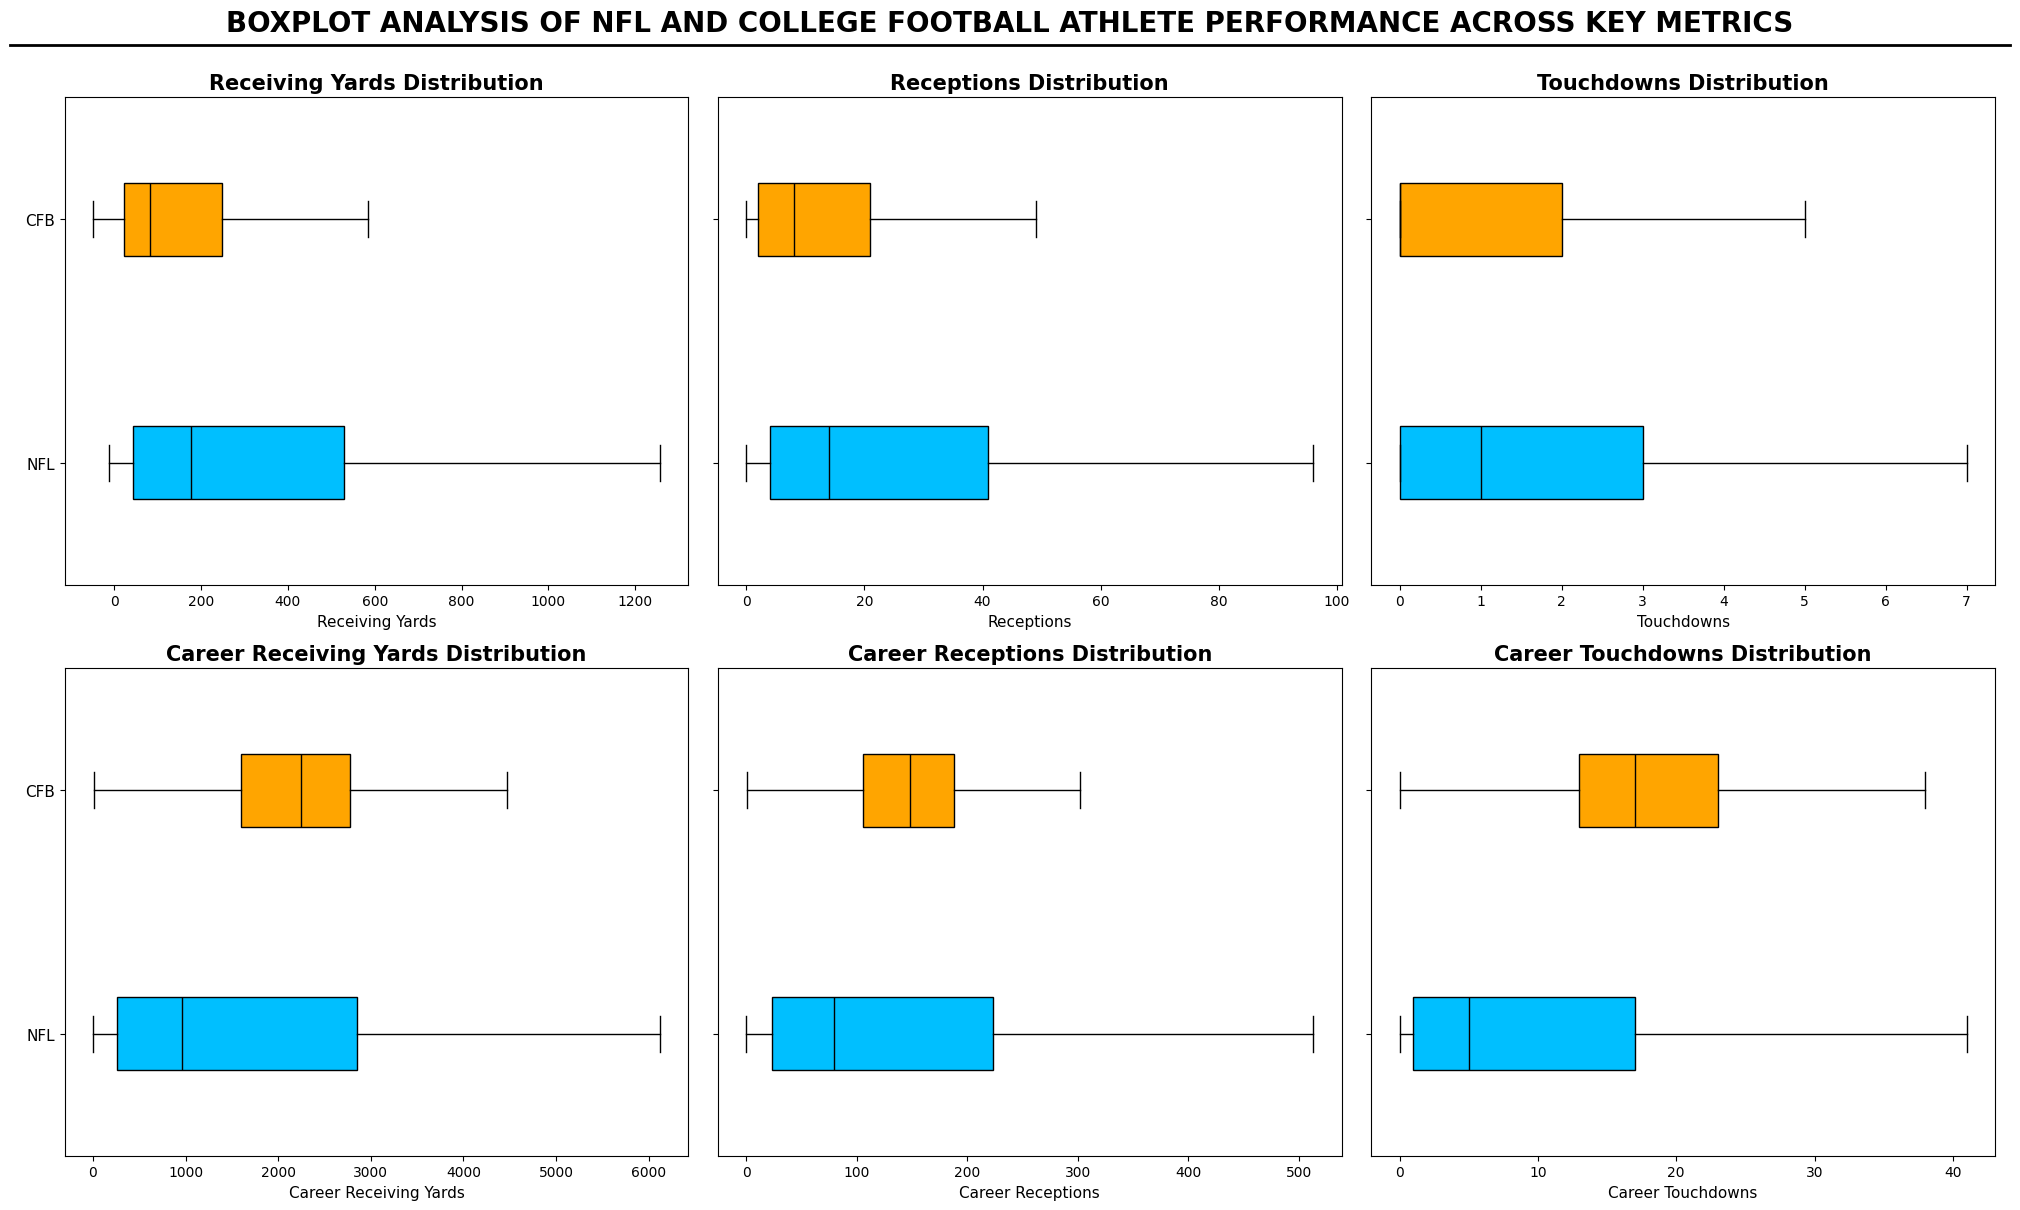

In [709]:
# GENERATE BOXPLOTS BY CAREER AND ANNUAL STATISTICS

# List metric and colors to be used in plots
metrics = ['receiving_yards', 'receptions', 'touchdowns']
boxplot_colors = ['orange', 'deepskyblue']

# Set up the figure with two rows and three columns for the subplots
fig, axes = plt.subplots(nrows= 2, ncols= 3, figsize= (20, 12), sharey= 'row', tight_layout= True)

# Set standard fugure subtitle
standardized_figure_title(fig= fig, title= "Boxplot Analysis of NFL and College Football Athlete Performance Across Key Metrics")

# Loop through the metrics and create boxplots for college football (CFB) and NFL
for row in range(2):
    for col, metric in enumerate(metrics):
        # row = 0 for CFB, row = 1 for NFL career data
        if row == 0:
            data_to_plot = [df_CFB[metric], df_NFL[metric]]
            title = f'{metric.replace("_", " ").title()} Distribution'
        else:
            data_to_plot = [df_CFB_career[metric], df_NFL_career[metric]]
            title = f'Career {metric.replace("_", " ").title()} Distribution'
        
        # Create the boxplot for the current metric
        boxplot_elements = axes[row, col].boxplot(
            data_to_plot, vert= False, patch_artist= True, showfliers= False, widths= 0.3, positions= [2, 1]
        )

        # Color each box
        for patch, color in zip(boxplot_elements['boxes'], boxplot_colors):
            patch.set_facecolor(color)
        # Set the color of the median line
        for median in boxplot_elements['medians']:
            median.set_color('black')

        # Set titles and labels
        axes[row, col].set_title(title, fontweight= 'bold', fontsize= 15)
        axes[row, col].set_yticks([1, 2])
        axes[row, col].set_yticklabels(['NFL', 'CFB'], fontsize= 11)
        if row < 1:
            if metric == 'receiving_yards': xlabel = " ".join(title.split(" ")[:2])
            else: xlabel = title.split(" ")[0]
        else:
            if metric == 'receiving_yards': xlabel = " ".join(title.split(" ")[:3])
            else: xlabel = " ".join(title.split(" ")[:2])
        axes[row, col].set_xlabel(xlabel, fontsize= 11)

# Display the plot
plt.show()

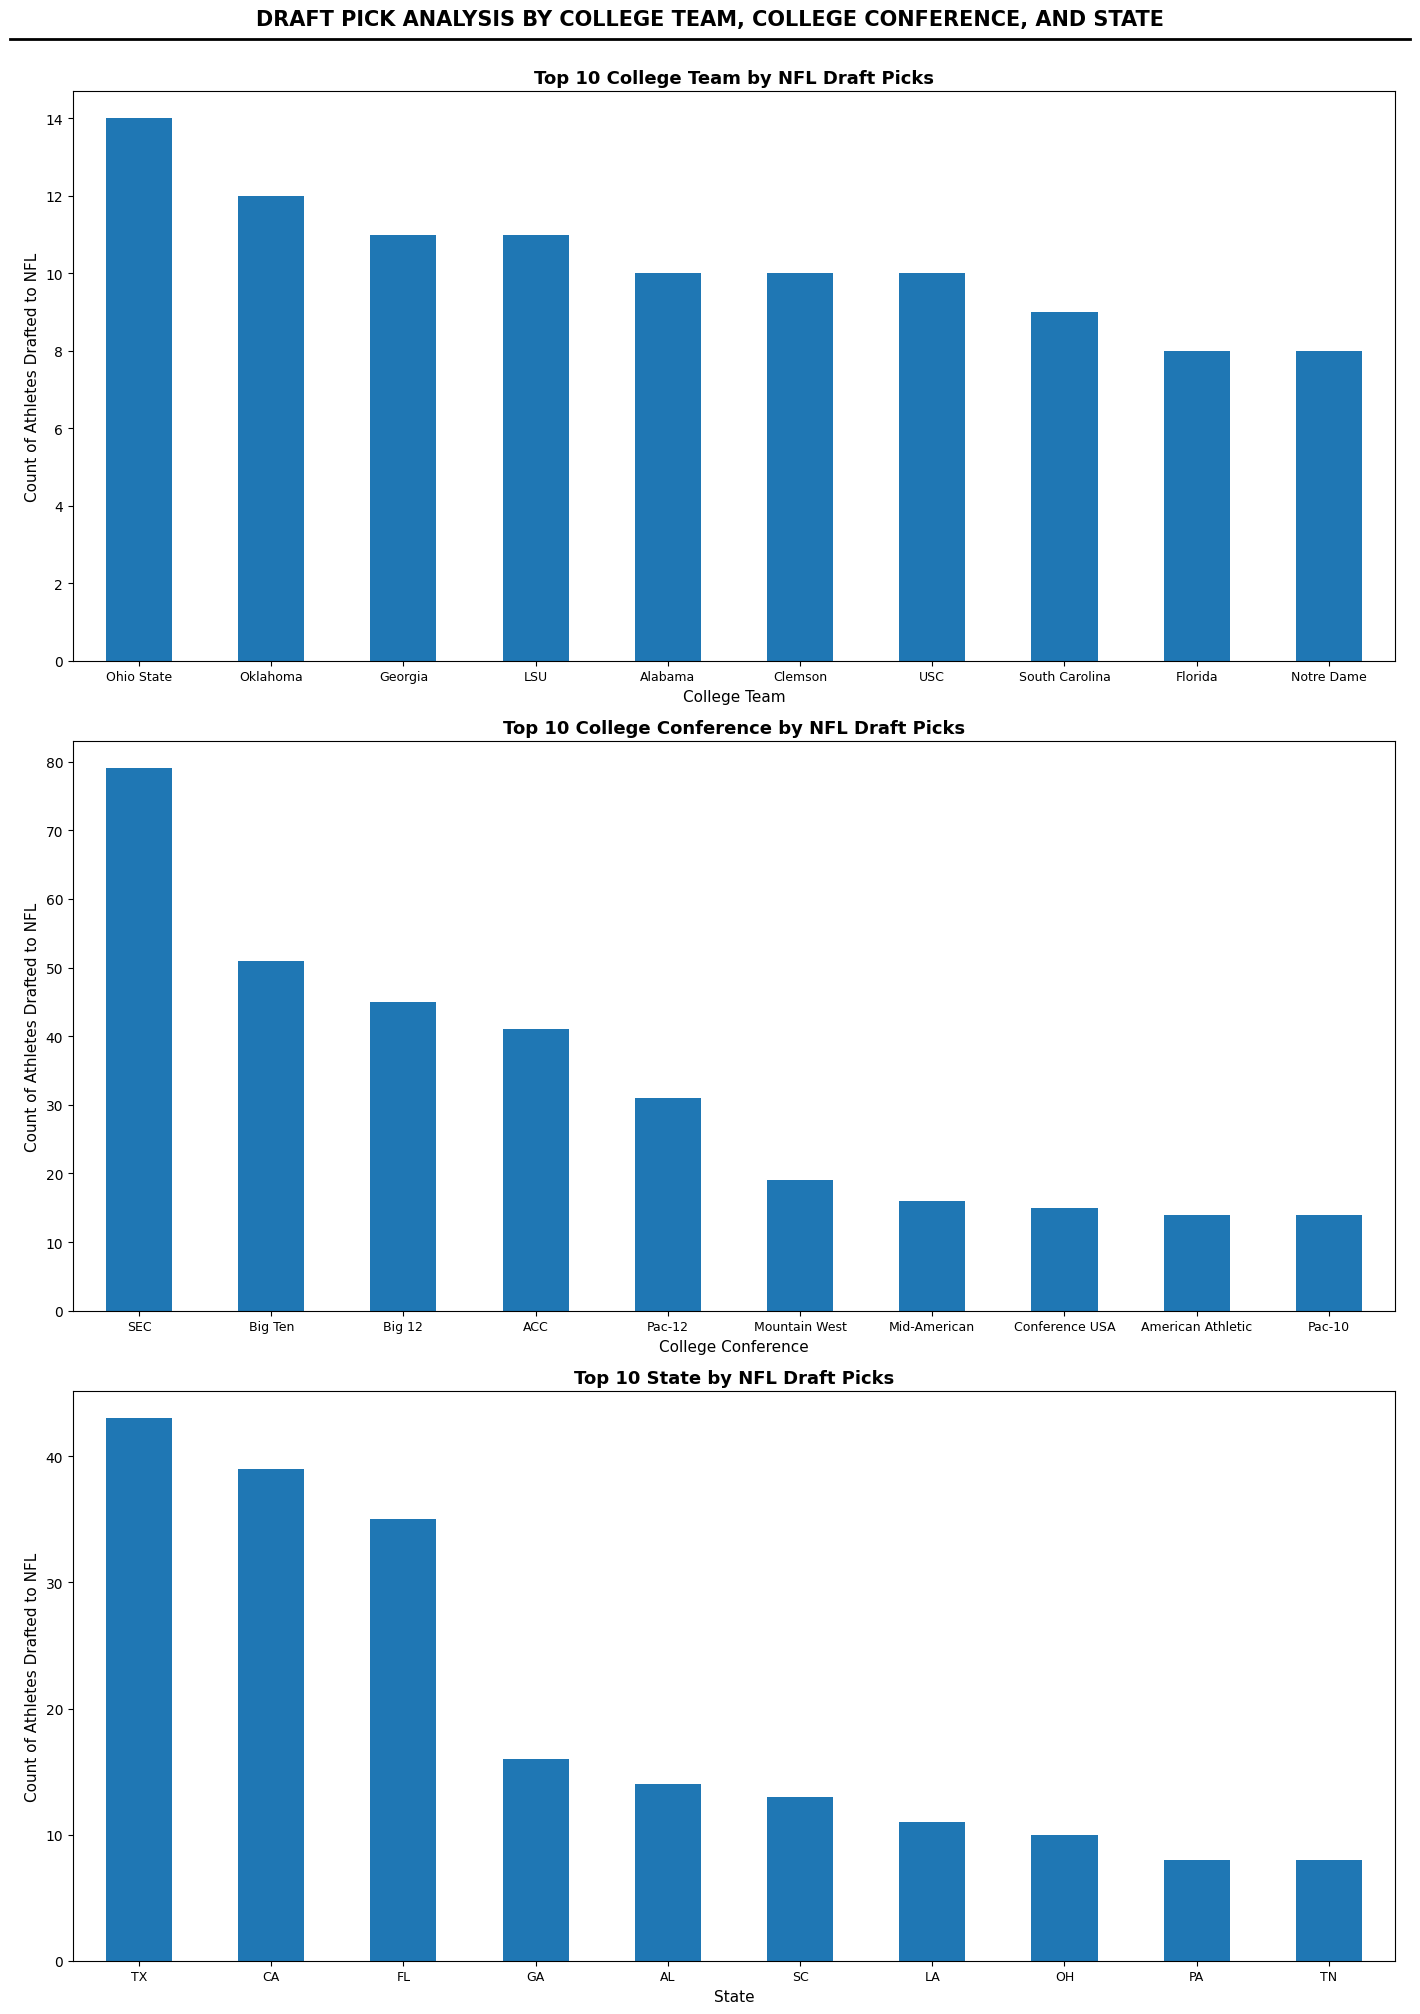

In [710]:
# GENERATE BAR GRAPHS TO DESCRIBE THE DRAFT INFORMATION

# Create factor list to be looped through
factors = ['college_team', 'college_conference', 'state']

# Initialize the plot
fig, axes = plt.subplots(nrows= 3, ncols= 1, figsize= (20, 80), tight_layout= True)

standardized_figure_title(
    fig= fig, underline_diff= 0.015, fontsize= 15, title= "Draft Pick Analysis by College Team, College Conference, and State"
)

# Loop through the factors to make a bar chart for each
for i, factor in enumerate(factors):
    factor_display_name = factor.replace('_', ' ').title()
    
    # Group by factor to make a bar chart for top 10
    df_draft.groupby(by= [factor]).size().nlargest(10).plot(kind= 'bar', ax= axes[i], figsize= (14, 20))
    
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation= 0, fontsize= 9)
    
    # Set labels and title
    axes[i].set_xlabel(factor_display_name, fontsize= 11)
    axes[i].set_ylabel('Count of Athletes Drafted to NFL', fontsize= 11)
    axes[i].set_title(f'Top 10 {factor_display_name} by NFL Draft Picks', fontweight= 'bold', fontsize= 13)

# Show the plot outside of the loop to render all subplots at once
plt.subplots_adjust(hspace= 1)
plt.show()

# MAYBE: Scale State representation by state population or college pop [**REMOVE ME**]

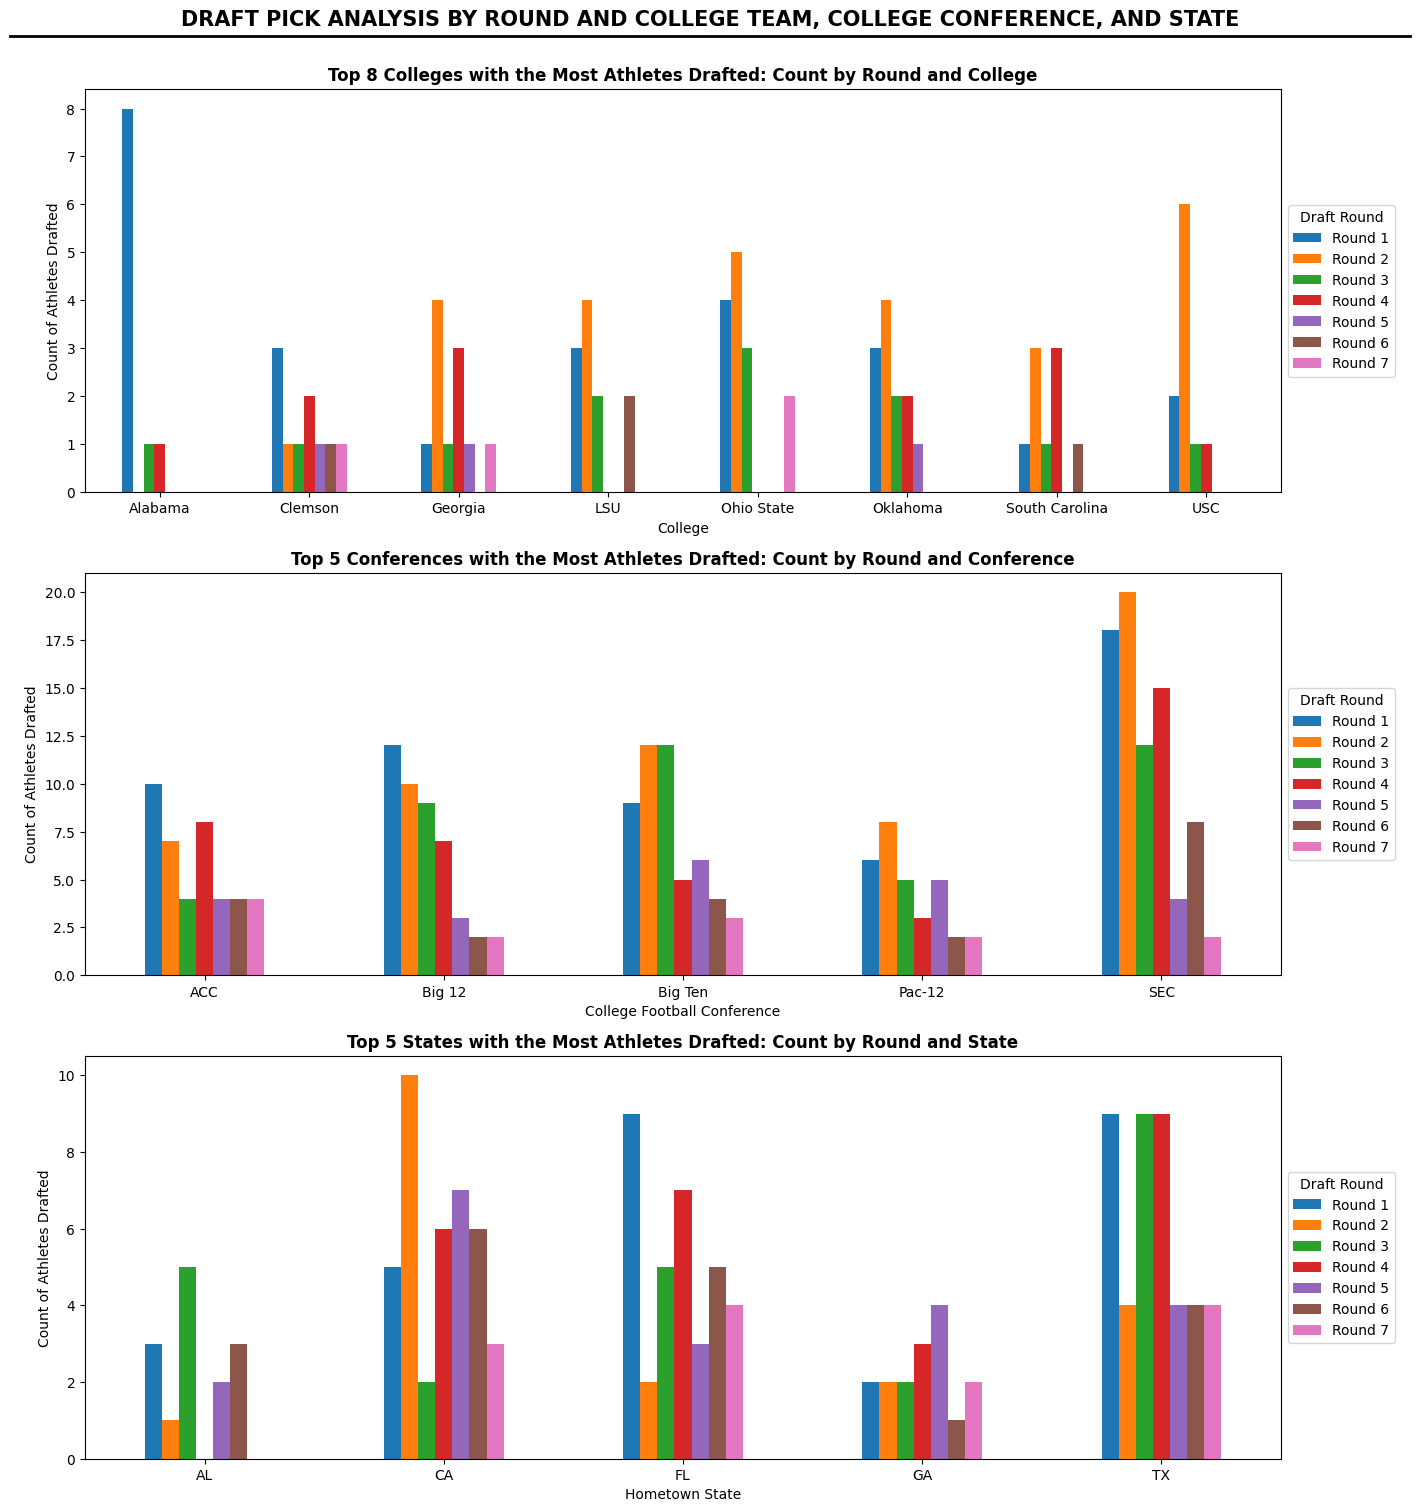

In [711]:
# GENERATE BAR GRAPHS TO DESCRIBE THE DRAFT INFORMATION

# Initialize the plot
fig, axes = plt.subplots(nrows= 3, ncols= 1, figsize= (20, 80), tight_layout= True)

standardized_figure_title(
    fig= fig, underline_diff= 0.0175, fontsize= 15, title= "Draft Pick Analysis by Round and College Team, College Conference, and State"
)

# List the categories per plots
categories = [['college_team', 'College', 'College'], 
              ['college_conference', 'College Football Conference', 'Conference'], 
              ['state', 'Hometown State', 'State']]

# Loop through category lists to create bar charts
for i, (category, xlabel, title) in enumerate(categories):
    # Group by categories for the top 5 (top 8 for count of athletes drafted due to interesting insight on Alabama)
    top_items = df_draft.groupby(by= category).size().nlargest(8 if i == 0 else 5).index
    
    # Create pivot table to prep for bar chart
    ptable = df_draft[df_draft[category].isin(top_items)].pivot_table(
        index= category, columns= 'round', values= 'athlete', aggfunc= 'count'
    )
    ptable_clean = ptable.fillna(0)

    # Apply graph attributes: legend, title, axis labels, etc.
    legend_labels = [f'Round {round_num}' for round_num in ptable_clean.columns]
    ptable_clean.plot(kind= 'bar', ax= axes[i], figsize= (14, 15))
    axes[i].legend(title= 'Draft Round', labels= legend_labels, loc= 'center left', bbox_to_anchor= (1, 0.5))
    axes[i].set_xticks(range(len(ptable_clean.index)))
    axes[i].set_xticklabels(ptable_clean.index, rotation= 0)
    axes[i].set_xlabel(xlabel)
    axes[i].set_ylabel('Count of Athletes Drafted')
    axes[i].set_title(f'Top {len(ptable_clean.index)} {title}s with the Most Athletes Drafted: Count by Round and {title}', fontweight= 'bold')

# Show plot
plt.show()

# Metric Scaling

In [712]:
# CODE TO SCALE ALL OF THE PLAYER STATISTICS

# Initialize the dataframe scalers for all three dataframes
cfb_scaler = StandardScaler()
nfl_scaler = StandardScaler()
draft_scaler = StandardScaler()

# Fit the scalers on the data and transform them to get z-scores for all three dataframes
cfb_scaled_data = cfb_scaler.fit_transform(df_CFB_career[['receiving_yards', 'receptions', 'touchdowns', 'avg_yards_rec']])
nfl_scaled_data = nfl_scaler.fit_transform(df_NFL_career[['receiving_yards', 'receptions', 'touchdowns', 'avg_yards_rec']])
draft_scaled_data = draft_scaler.fit_transform(df_draft[[
    'height', 'overall', 'pre_draft_grade', 'pre_draft_position_ranking', 'pre_draft_ranking', 'round', 'weight'
]])

# Create placeholder dataFrames from the scaled data for all three dataframes
df_CFB_scaled = pd.DataFrame(cfb_scaled_data, columns= [
    'z_receiving_yards_cfb', 'z_receptions_cfb', 'z_touchdowns_cfb', 'z_avg_yards_rec_cfb'
], index= df_CFB_career.index)
df_NFL_scaled = pd.DataFrame(nfl_scaled_data, columns= [
    'z_receiving_yards_nfl', 'z_receptions_nfl', 'z_touchdowns_nfl', 'z_avg_yards_rec_nfl'
], index= df_NFL_career.index)
df_draft_scaled = pd.DataFrame(draft_scaled_data, columns= [
    'z_height', 'z_overall', 'z_pre_draft_grade', 'z_pre_draft_position_ranking', 'z_pre_draft_ranking', 
    'z_round', 'z_weight'
], index= df_draft.index)

# Calculate composite scores by summing the z-scores of each stat for all three dataframes
df_CFB_scaled['cfb_composite_score'] = df_CFB_scaled.sum(axis= 1)
df_NFL_scaled['nfl_composite_score'] = df_NFL_scaled.sum(axis= 1)
df_draft_scaled['draft_composite_score'] = df_draft_scaled.sum(axis= 1)

# Integrate the scaled statistics and composite scores back into the original three dataframes
df_CFB_career = df_CFB_career.join(df_CFB_scaled)
df_NFL_career = df_NFL_career.join(df_NFL_scaled)
df_draft = df_draft.join(df_draft_scaled)

# Aggregate Datasets

In [713]:
# Merge CFB, NFL, and draft dataframes on shared athlete ID to form aggregate dataframe
df_aggregated = pd.merge(df_NFL_career, df_CFB_career[[
    'name_year', 'z_receiving_yards_cfb', 'z_receptions_cfb', 'z_touchdowns_cfb', 
    'z_avg_yards_rec_cfb', 'cfb_composite_score', 'common_athlete_id'
]], on= 'common_athlete_id').merge(df_draft[[
    'name_year', 'z_height', 'z_overall', 'z_pre_draft_grade', 'z_pre_draft_position_ranking', 'z_pre_draft_ranking', 
    'z_round', 'z_weight', 'overall', 'round', 'pre_draft_grade', 'common_athlete_id'
]], on= 'common_athlete_id')

# Preliminary Data Correlation Analysis

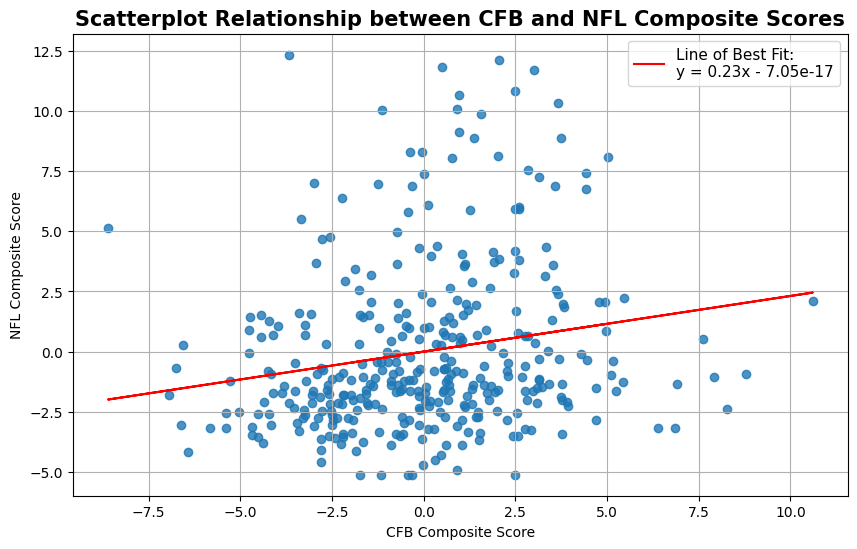

In [714]:
# CODE TO PERFORM A PRELIMINARY CORRELATION ANALYSIS

# Load the CFB and NFL data into x and y
x = df_aggregated['cfb_composite_score']
y = df_aggregated['nfl_composite_score']

# Compute line of best fit
slope, intercept =  np.polyfit(x, y, 1)
line = slope * x + intercept


# Prepare the figure
fig, ax = plt.subplots(figsize= (10, 6))
ax.scatter(x, y, alpha= 0.8)

# Plot the line of best fit
abs_intercept = intercept * -1
ax.plot(x, line, color= 'r', label= f'Line of Best Fit:\ny ={slope: .2f}x - {abs_intercept:.2e}')

# Format the plot
ax.set_title('Scatterplot Relationship between CFB and NFL Composite Scores', fontweight= 'bold', fontsize= 15)
ax.set_xlabel('CFB Composite Score')
ax.set_ylabel('NFL Composite Score')
ax.legend(fontsize= 11, loc= 'best')
ax.grid(True)

# Show the plot
plt.show()

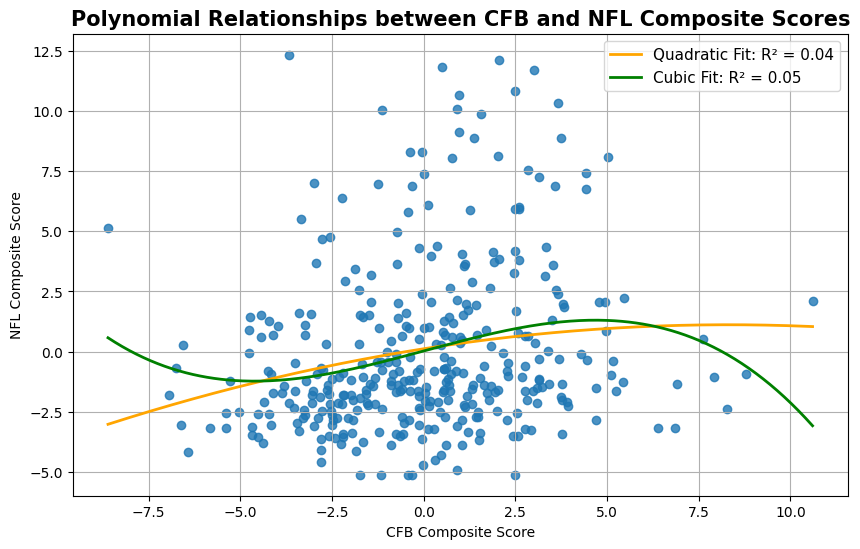

In [715]:
# Fit polynomial models

# Compute polynomial (quadratic and cubic) fits
p2 = np.polyfit(x, y, 2)
p3 = np.polyfit(x, y, 3)

# Calculate x values
x_line = np.linspace(x.min(), x.max(), 300)

# Calculate y values
y_p2 = np.polyval(p2, x_line)
y_p3 = np.polyval(p3, x_line)

# Calculate y values from the models on the original x data for R-squared calculation
y_fit_p2 = np.polyval(p2, x)
y_fit_p3 = np.polyval(p3, x)

# Calculate R-squared coefficients
ss_res_p2 = np.sum((y - y_fit_p2) ** 2)
ss_res_p3 = np.sum((y - y_fit_p3) ** 2)
ss_tot = np.sum((y - np.mean(y)) ** 2)
r_squared_p2 = 1 - (ss_res_p2 / ss_tot)
r_squared_p3 = 1 - (ss_res_p3 / ss_tot)

# Prepare the figure
fig, ax = plt.subplots(figsize= (10, 6))
ax.scatter(x, y, alpha= 0.8)

# Plot the line of best fits
ax.plot(x_line, y_p2, color= 'orange', linewidth= 2, label= f'Quadratic Fit: R² = {r_squared_p2:.2f}')
ax.plot(x_line, y_p3, color= 'green', linewidth= 2, label= f'Cubic Fit: R² = {r_squared_p3:.2f}')

# Format the plot
ax.set_title('Polynomial Relationships between CFB and NFL Composite Scores', fontweight= 'bold', fontsize= 15)
ax.set_xlabel('CFB Composite Score')
ax.set_ylabel('NFL Composite Score')
ax.legend(fontsize= 11, loc= 'best')
ax.grid(True)

# Show the plot
plt.show()

# Perform K-Means Clustering Analysis to Determine Success Cutoff

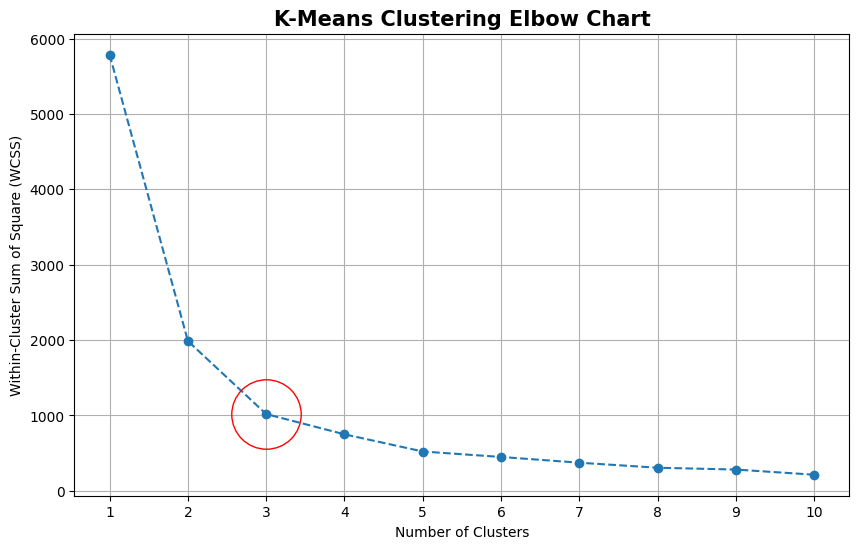

In [716]:
# Prepare the data for clustering
df_NFL_cluster = df_aggregated[['z_receiving_yards_nfl', 'z_receptions_nfl', 'z_touchdowns_nfl', 'z_avg_yards_rec_nfl', 'nfl_composite_score']]

# Initialize a list to store within-cluster sum of squares (WCSS) values
wcss = []

# Fit K-Means models with different numbers of clusters and calculate WCSS
for i in range(1, 11):
    kmeans = KMeans(n_clusters= i, init= 'k-means++', random_state= 42)
    kmeans.fit(df_NFL_cluster)
    wcss.append(kmeans.inertia_)

fig, ax = plt.subplots(figsize= (10,6))
ax.plot(range(1, 11), wcss, marker= 'o', linestyle= '--')
ax.plot(3, wcss[2], marker='o', linestyle='None', markersize=50, markerfacecolor='none', markeredgecolor='r')
ax.set_xticks(range(1, 11))
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Within-Cluster Sum of Square (WCSS)')
ax.set_title('K-Means Clustering Elbow Chart', fontweight= 'bold', fontsize= 15)
ax.grid(True)

plt.show()

In [717]:
# CODE TO APPLY THREE CLUSTERS TO THE AGGREAGATE DATA

# Perform K-Means clustering
kmeans = KMeans(n_clusters= 3, init= 'k-means++', random_state= 42)
df_aggregated['cluster'] = kmeans.fit_predict(df_NFL_cluster)
cluster_centers = kmeans.cluster_centers_

# Assign cluster labels to each row using custom function
df_aggregated['cluster_label'] = df_aggregated.apply(label_clusters, axis= 1)

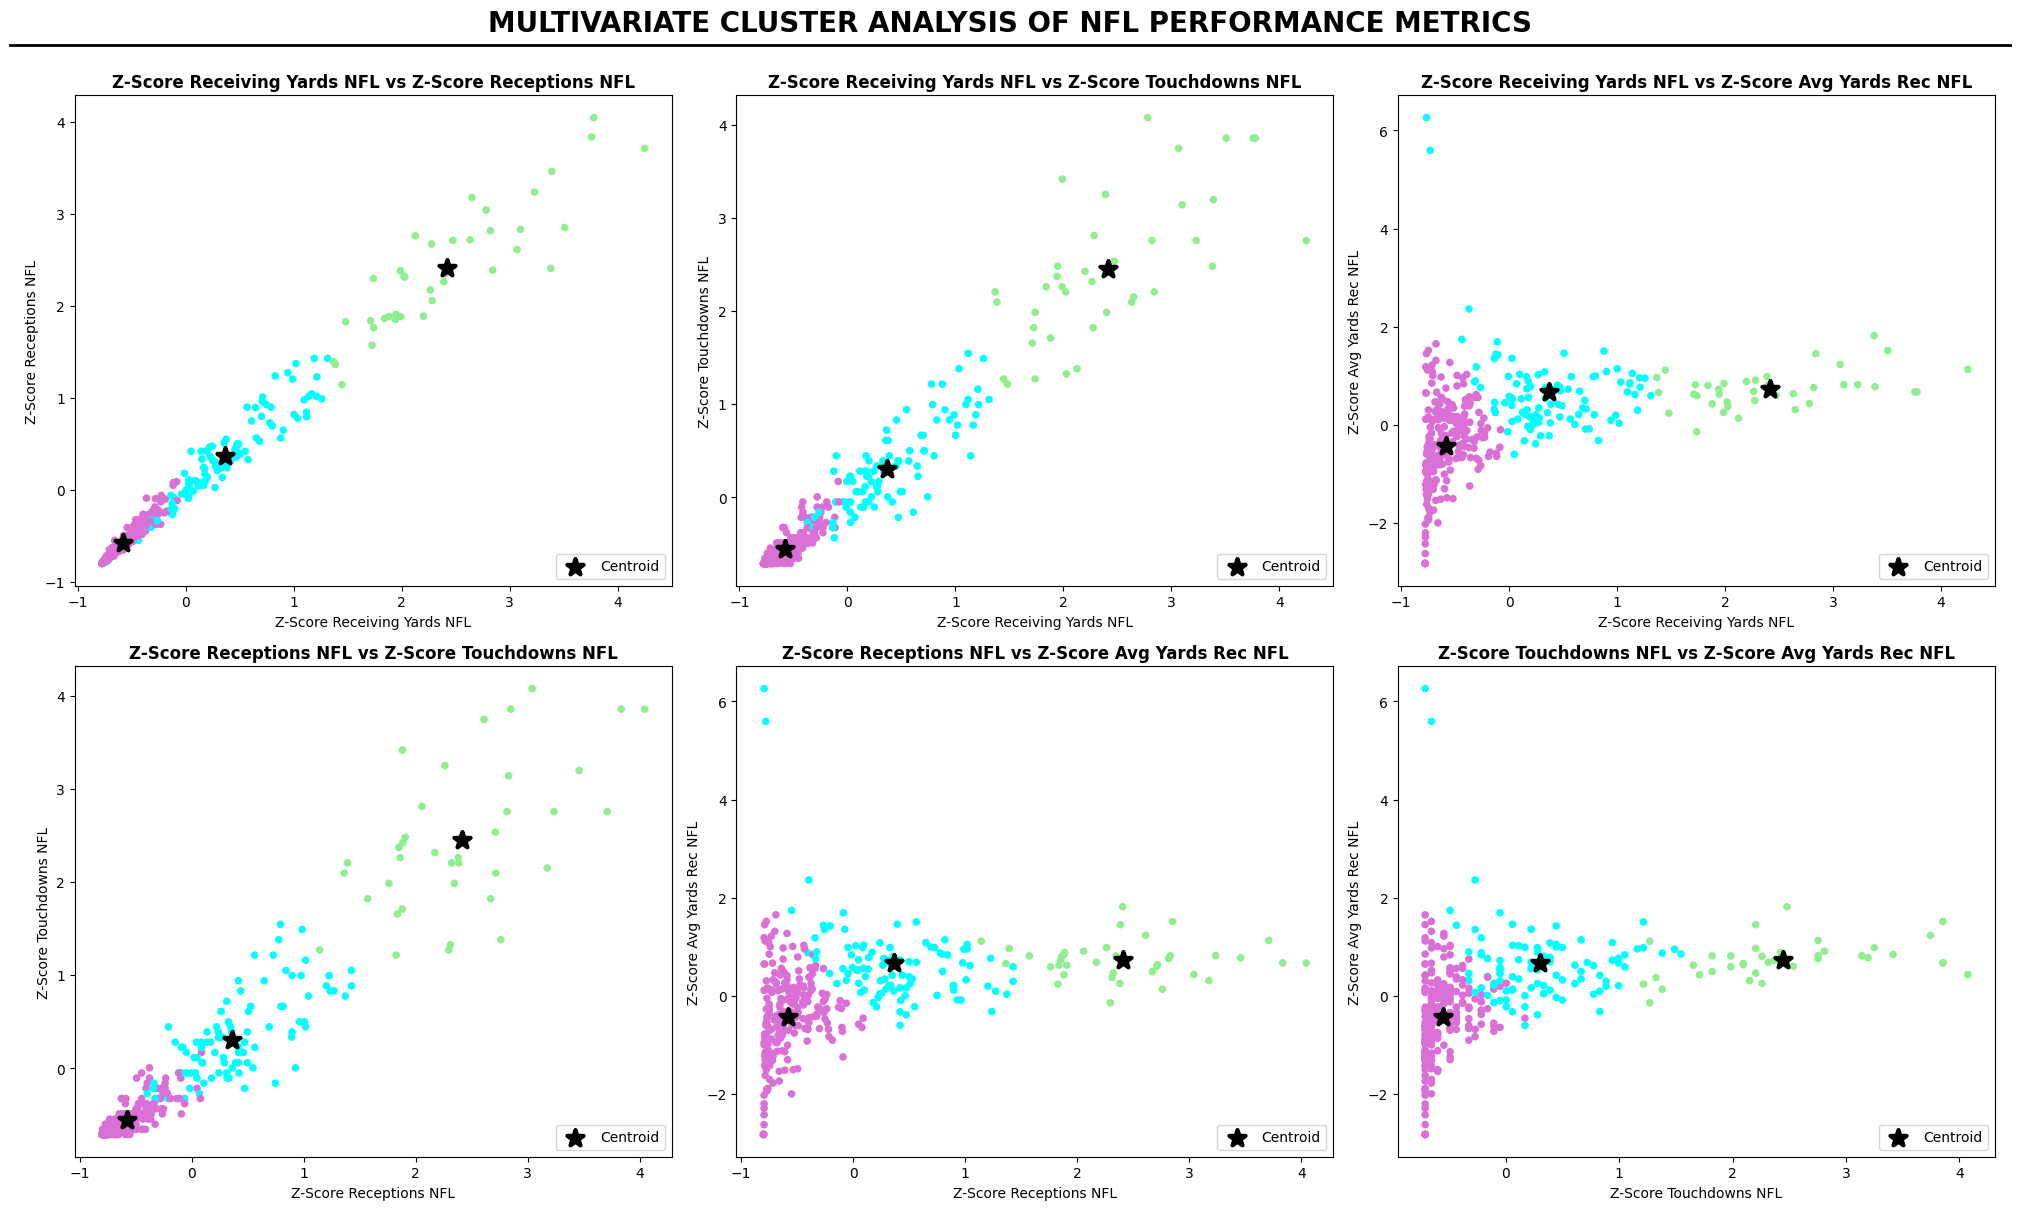

In [718]:
# Initialize list of scaled metrics and colors to be used in scatterplots
scaled_metrics = ['z_receiving_yards_nfl', 'z_receptions_nfl', 'z_touchdowns_nfl', 'z_avg_yards_rec_nfl']
metric_combos = [metric for metric in combinations(scaled_metrics, 2)]
cluster_colors = {0: 'cyan', 1: 'lightgreen', 2: 'orchid'}

# Create figure to hold subplots
fig, axes = plt.subplots(nrows= 2, ncols= 3, figsize= (20, 12), tight_layout= True)
axes = axes.flatten()

# Graph each of the six figures and include a marker to represent the average (centroid) within each cluster
for num, (metric_x, metric_y) in enumerate(metric_combos):
    x_index = scaled_metrics.index(metric_x)
    y_index = scaled_metrics.index(metric_y)
    name1 = metric_x.replace('_', ' ').title().replace('Z', 'Z-Score').replace('Nfl', 'NFL')
    name2 = metric_y.replace('_', ' ').title().replace('Z', 'Z-Score').replace('Nfl', 'NFL')
    axes[num].scatter(df_NFL_cluster[metric_x], df_NFL_cluster[metric_y], c=df_aggregated['cluster'].map(cluster_colors), s= 20)
    centroid_scat = axes[num].scatter(cluster_centers[:, x_index], cluster_centers[:, y_index], s= 150, c= 'black', marker= '*', linewidth= 3)
    axes[num].set_title(f'{name1} vs {name2}', fontweight= 'bold')
    axes[num].set_xlabel(name1)
    axes[num].set_ylabel(name2)
    axes[num].legend([centroid_scat], ['Centroid'], loc= 'lower right')

standardized_figure_title(fig= fig, title= "Multivariate Cluster Analysis of NFL Performance Metrics")

plt.show()

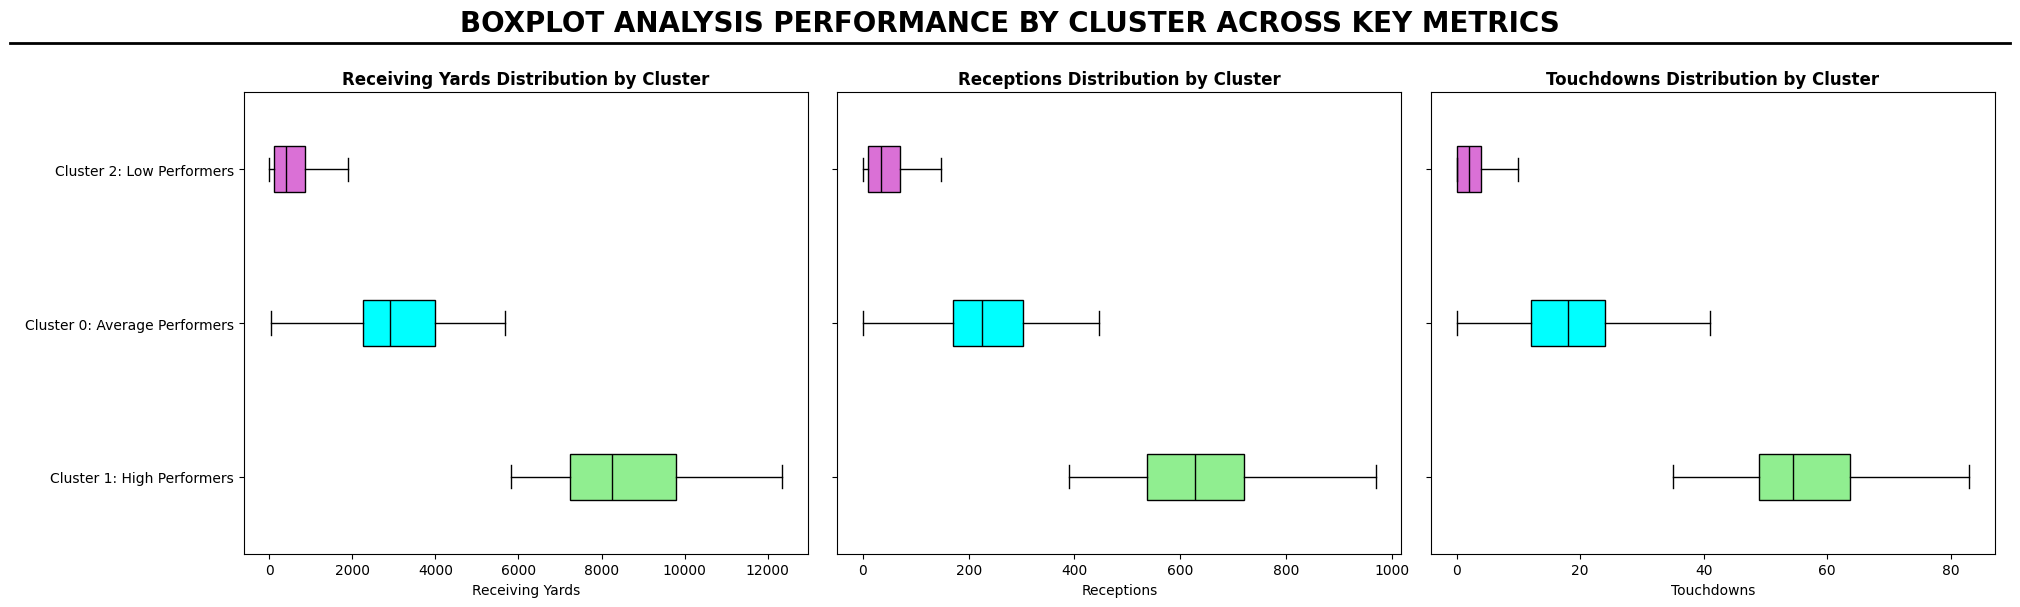

In [719]:
# GENERATE BOXPLOTS BY CLUSTER

# List metric and colors to be used in plots
metrics = ['receiving_yards', 'receptions', 'touchdowns']

# Set up the figure with one row and three columns for the subplots
fig, axes = plt.subplots(nrows= 1, ncols= 3, figsize= (20, 6), sharey= True, tight_layout= True)

# Loop through the metrics and create boxplots for each cluster within each metric
for i, metric in enumerate(metrics):
    # Get the data for each cluster for the current metric in the order of high, average, low
    data_to_plot = [
        df_aggregated[df_aggregated['cluster'] == 1][metric],  # High
        df_aggregated[df_aggregated['cluster'] == 0][metric],  # Average
        df_aggregated[df_aggregated['cluster'] == 2][metric]   # Low
    ]
    
    # Create the boxplot for the current metric
    boxplot_elements = axes[i].boxplot(data_to_plot, vert= False, patch_artist= True, showfliers= False, widths= 0.3)

    # Match the colors with the new order of data
    adjusted_cluster_colors = ['lightgreen', 'cyan', 'orchid']  # High, Average, Low
    
    for patch, color in zip(boxplot_elements['boxes'], adjusted_cluster_colors):
        patch.set_facecolor(color)
    for median in boxplot_elements['medians']:
        median.set_color('black')
    
    # Update the title for each subplot
    axes[i].set_title(f'{metric.replace("_", " ").title()} Distribution by Cluster', fontweight= 'bold')
    
    # Set the yticks to match the data order
    axes[i].set_yticks([1, 2, 3])
    
    # Set axis labels
    axes[i].set_yticklabels(['Cluster 1: High Performers', 'Cluster 0: Average Performers', 'Cluster 2: Low Performers'])
    axes[i].set_xlabel(metric.replace('_', ' ').title())

standardized_figure_title(fig= fig, title= "Boxplot Analysis Performance by Cluster Across Key Metrics", underline_diff= 0.057)
# Display the plot
plt.show()


# Feature Engineering

#### Feature Ideation

In [720]:
# Add interactive features to the aggregate dataframe
df_aggregated['height_weight'] = df_aggregated['z_height'] * df_aggregated['z_weight']
df_aggregated['grade_round'] = df_aggregated['z_pre_draft_grade'] * df_aggregated['z_round']
df_aggregated['grade_pick'] = df_aggregated['z_pre_draft_grade'] * df_aggregated['z_overall']
df_aggregated['overall_round'] = df_aggregated['z_overall'] * df_aggregated['z_round']
df_aggregated['overall_ranking'] = df_aggregated['z_overall'] * df_aggregated['z_pre_draft_ranking']
df_aggregated['yards_td'] = df_aggregated['z_receiving_yards_cfb'] * df_aggregated['z_touchdowns_cfb']
df_aggregated['rec_td'] = df_aggregated['z_receptions_cfb'] * df_aggregated['z_touchdowns_cfb']
df_aggregated['grade_height_interaction'] = df_aggregated['z_pre_draft_grade'] * df_aggregated['z_height']
df_aggregated['grade_weight_interaction'] = df_aggregated['z_pre_draft_grade'] * df_aggregated['z_weight']

# Add polynomial features to the aggregate dataframe
df_aggregated['round_squared'] = df_aggregated['z_round'] ** 2
df_aggregated['overall_sqaured'] = df_aggregated['z_overall'] ** 2
df_aggregated['round_cubed'] = df_aggregated['z_round'] ** 3
df_aggregated['overall_cubed'] = df_aggregated['z_overall'] ** 3

# Add one-hot encoded columns for height and weight to create height and weight bins to the aggregate dataframe
df_aggregated['height_bin'] = pd.cut(df_aggregated['z_height'], bins= 3, labels= ['short', 'average', 'tall'])
df_aggregated['weight_bin'] = pd.cut(df_aggregated['z_weight'], bins= 3, labels= ['light', 'average', 'heavy'])
df_aggregated = pd.get_dummies(df_aggregated, columns= ['height_bin', 'weight_bin'])

#### Feature Analysis

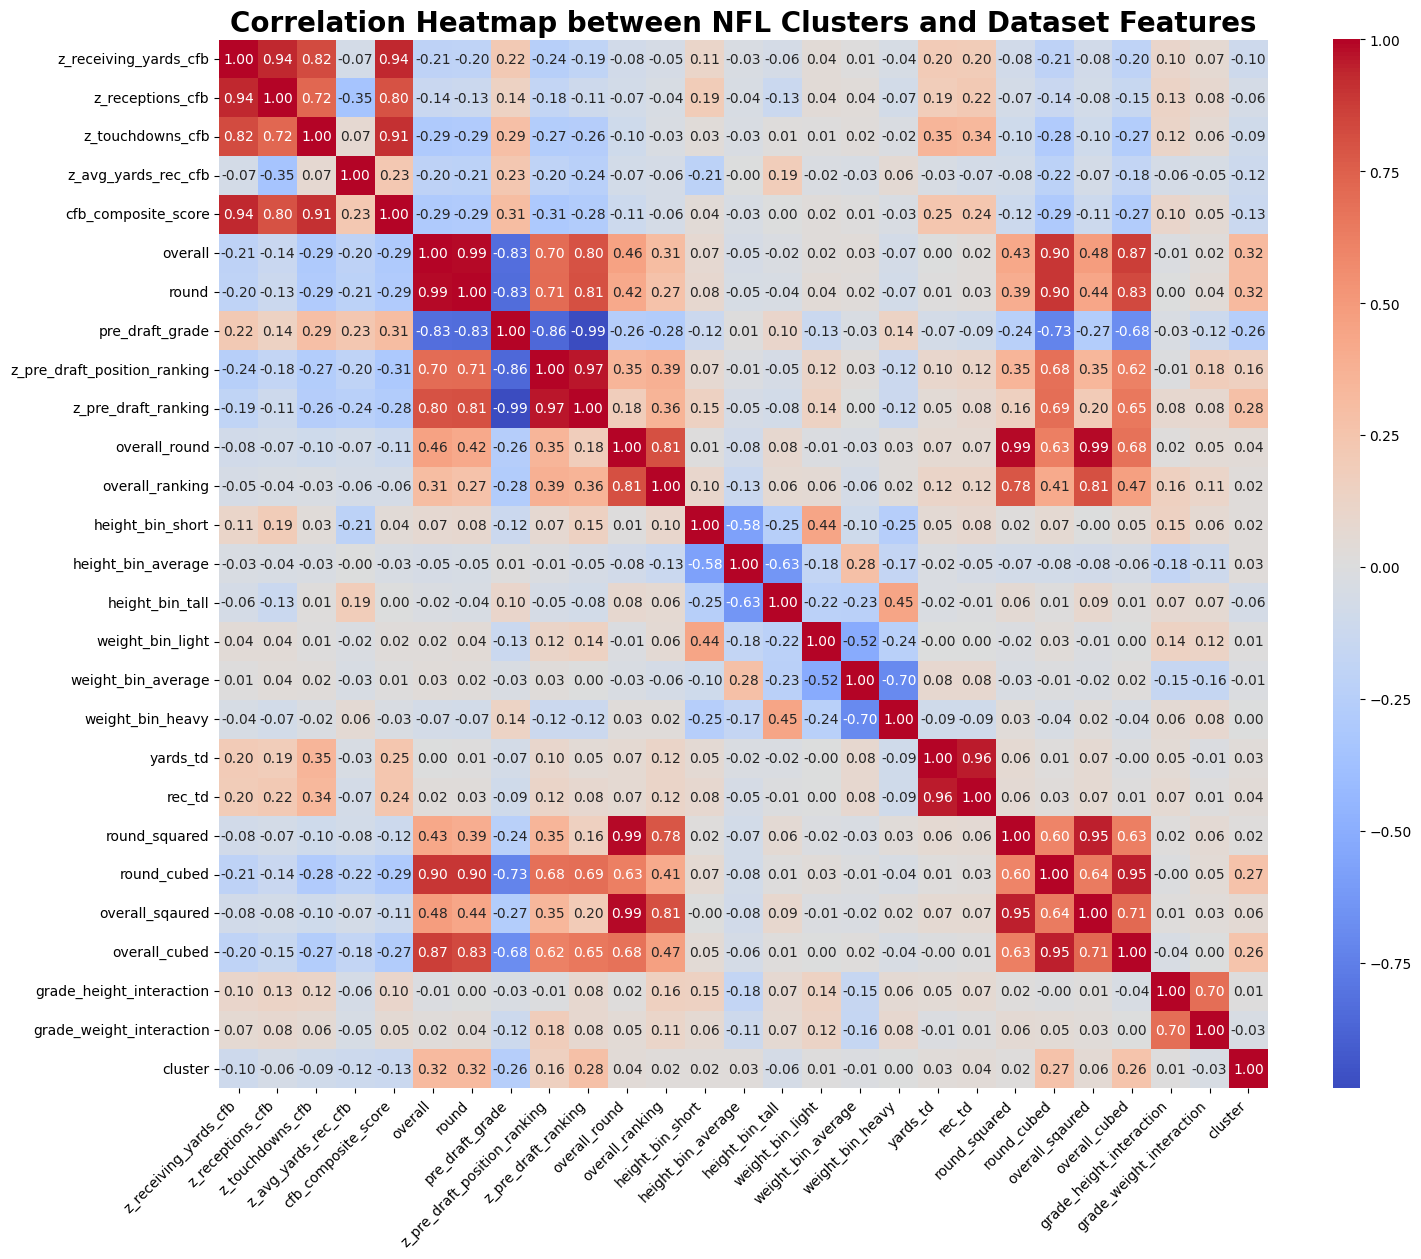

In [721]:
# GENERATE HEATMAPS TO ILLUSTRATE FEATURE CORRELATION

# Generate heatmaps to illustrate feature correlation
heatmap_columns = [
    'z_receiving_yards_cfb', 'z_receptions_cfb', 'z_touchdowns_cfb', 'z_avg_yards_rec_cfb',
    'cfb_composite_score', 'overall', 'round', 'pre_draft_grade', 'z_pre_draft_position_ranking', 
    'z_pre_draft_ranking', 'overall_round', 'overall_ranking', 'height_bin_short', 'height_bin_average', 'height_bin_tall', 
    'weight_bin_light', 'weight_bin_average', 'weight_bin_heavy', 'yards_td', 'rec_td', 'round_squared', 'round_cubed',
    'overall_sqaured', 'overall_cubed', 'grade_height_interaction', 'grade_weight_interaction'
]

# Include the cluster labels in the numerical data
numerical_data = df_aggregated[heatmap_columns + ['cluster']]

# Calculate the correlation matrix
correlation_matrix = numerical_data.corr()

# Create the figure and axis objects
fig, ax = plt.subplots(figsize= (15.5, 15.5), tight_layout= True)

# Create the heatmap on the axis
sns.heatmap(correlation_matrix, annot= True, fmt= '.2f', cmap= 'coolwarm', square= True, cbar_kws= {"shrink": .69, "aspect": 40}, ax= ax)

# Set the title
ax.set_title('Correlation Heatmap between NFL Clusters and Dataset Features', fontweight= 'bold', fontsize = 20)

# Rotate the x labels for better readability
plt.xticks(rotation= 45, ha= 'right')

# Display the plot
plt.show()

# Apply ML Models for Prediction Analysis

In [722]:
# PREPARE DATA FOR ML MODELS

# List out all 27 features available
feature_columns = [
    'z_receiving_yards_cfb', 'z_receptions_cfb', 'z_touchdowns_cfb', 'z_avg_yards_rec_cfb',
    'cfb_composite_score', 'overall', 'round', 'pre_draft_grade', 'z_pre_draft_position_ranking', 
    'z_pre_draft_ranking', 'overall_round', 'overall_ranking', 'height_bin_short', 'height_bin_average', 'height_bin_tall', 
    'weight_bin_light', 'weight_bin_average', 'weight_bin_heavy', 'yards_td', 'rec_td', 'round_squared', 'round_cubed',
    'overall_sqaured', 'overall_cubed', 'grade_height_interaction', 'grade_weight_interaction', 'cluster'
]

# Create a feature only dataset
df_features = df_aggregated[feature_columns]

# Split up the data
X = df_features.drop(['cluster'], axis= 1)  # Features
y = df_features['cluster']  # Target variable

# Split the data into a training set (70%) and a test set (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 42, stratify= y)

#### Niave Model Baseline

Naive Baseline: Train Accuracy: 0.4457831325301205
Naive Baseline: Test Accuracy: 0.4537037037037037

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.24      0.23      0.24        30
           1       0.14      0.18      0.16        11
           2       0.62      0.60      0.61        67

    accuracy                           0.45       108
   macro avg       0.33      0.34      0.33       108
weighted avg       0.46      0.45      0.46       108

Confusion Matrix (Test Set):
[[ 7  4 19]
 [ 3  2  6]
 [19  8 40]]


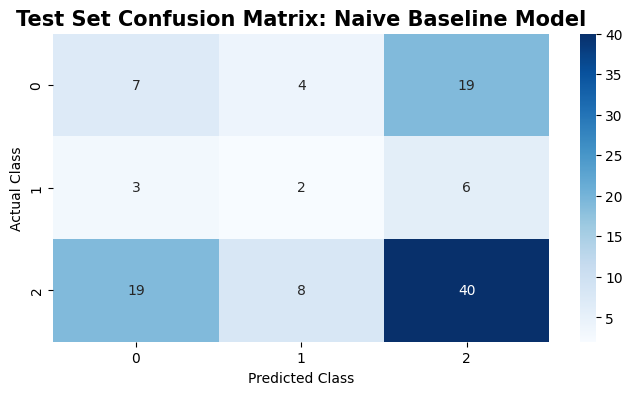

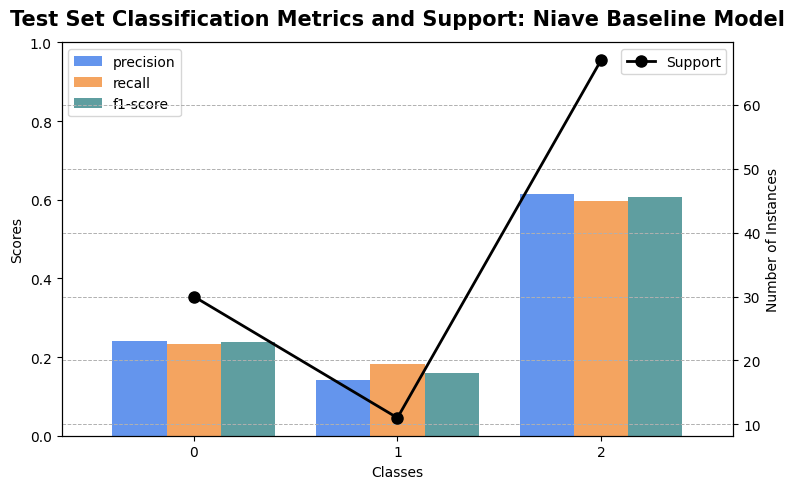

In [723]:
# GENERATE A NAIVE BASELINE MODEL

# Compute dummy train of data
dummy_clf = DummyClassifier(strategy= "stratified", random_state= 42)
dummy_clf.fit(X_train, y_train)

# Make predictions on the training set and test set
y_train_pred = dummy_clf.predict(X_train)
y_test_pred = dummy_clf.predict(X_test)

# Evaluate the performance of the naive model
print("Naive Baseline: Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Naive Baseline: Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred, zero_division= 0))
print("Confusion Matrix (Test Set):")
print(confusion_matrix(y_test, y_test_pred))

# Generate the confusion matrix and classification report
cm = confusion_matrix(y_test, y_test_pred)
report = classification_report(y_test, y_test_pred, zero_division= 0, output_dict= True)

plot_confusion_matrix(cm= cm, class_labels= [0, 1, 2], title=  'Test Set Confusion Matrix: Naive Baseline Model')
plot_classification_report(report= report, title=  'Test Set Classification Metrics and Support: Niave Baseline Model')

#### Decision Tree Model (basic)

Optimal Number of Features: 8
Optimal Features:
z_receptions_cfb
z_touchdowns_cfb
z_avg_yards_rec_cfb
pre_draft_grade
z_pre_draft_ranking
yards_td
overall_cubed
grade_height_interaction


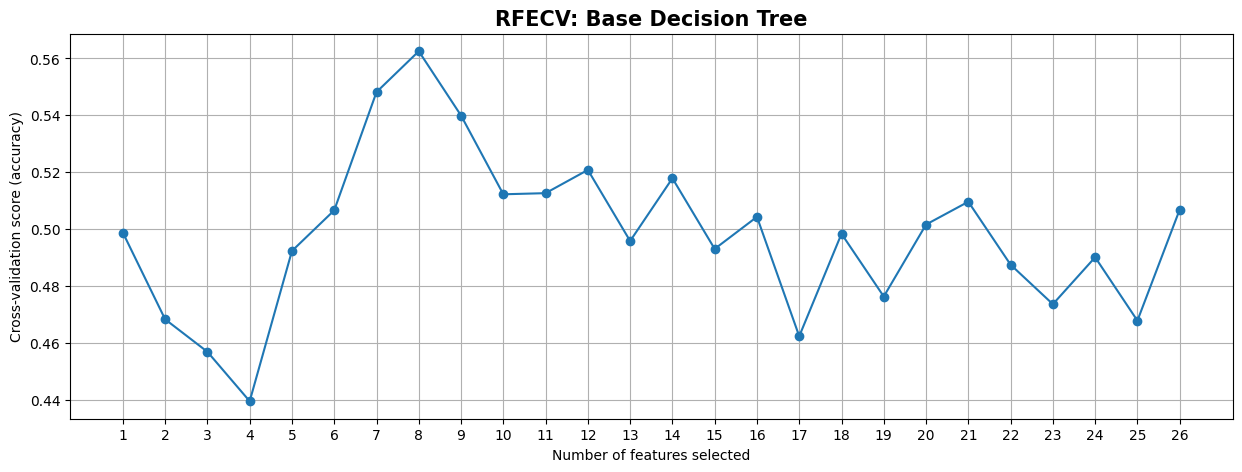

In [724]:
# DETERMINE BEST FEATURES TO USE IN A DECISION TREE MODEL

# Create and fit RFECV for a decision tree
dt_classifier = DecisionTreeClassifier(random_state= 42)
rfecv_dt = RFECV(estimator= dt_classifier, step= 1, cv= StratifiedKFold(10), scoring= 'accuracy')
rfecv_dt.fit(X, y)

# Analyze RFECV recommendations
print("Optimal Number of Features:", rfecv_dt.n_features_)
print("Optimal Features:")

# Assign optimal features to X for decision tree
dt_optimal_features = X.columns[rfecv_dt.support_].tolist()
X_dt = X[dt_optimal_features]

# Print optimal features
for feature in dt_optimal_features:
    print(feature)

# Plot RFECV features
plot_rfecv_results(rfecv_dt, X, 'RFECV: Base Decision Tree')


In [725]:
# DETERMINE BEST PARAMETERS TO USE IN A DECISION TREE MODEL

# Define a set of parameters to test
param_grid = {
    'max_depth': [2, 3, 5, 7, 9],
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [2, 3, 4],
}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator= DecisionTreeClassifier(random_state= 42), param_grid= param_grid, cv= 5, n_jobs=- 1, scoring= 'accuracy')

# Fit the object to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:")
print(best_params)

print("Best Score:")
print(best_score)

# Train a new classifier using the best parameters found
best_classifier = DecisionTreeClassifier(**best_params, random_state= 42)
best_classifier.fit(X_train, y_train)

# Predict on the test data using the best classifier
y_pred_best = best_classifier.predict(X_test)

# Evaluate the new model
print("Improved Classification Report:")
print(classification_report(y_test, y_pred_best, zero_division= 0))

Best Parameters:
{'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 2}
Best Score:
0.6304489795918368
Improved Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.20      0.25        30
           1       0.50      0.09      0.15        11
           2       0.65      0.85      0.74        67

    accuracy                           0.59       108
   macro avg       0.49      0.38      0.38       108
weighted avg       0.55      0.59      0.54       108



Classification Report:
              precision    recall  f1-score   support

           0       0.08      0.03      0.05        32
           1       0.00      0.00      0.00        11
           2       0.57      0.85      0.68        65

    accuracy                           0.52       108
   macro avg       0.22      0.29      0.24       108
weighted avg       0.37      0.52      0.42       108

Confusion Matrix:
[[ 1  0 31]
 [ 1  0 10]
 [10  0 55]]
Accuracy Score:
0.5185185185185185


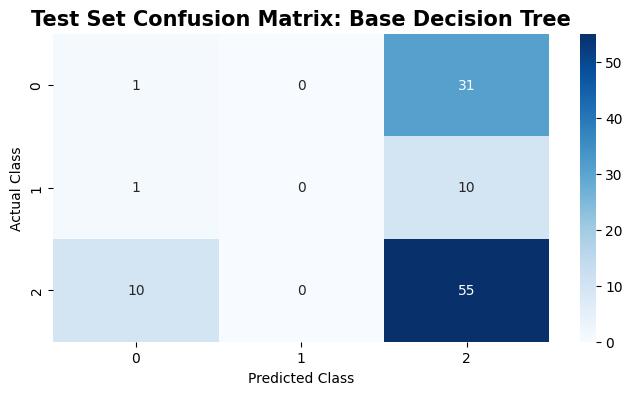

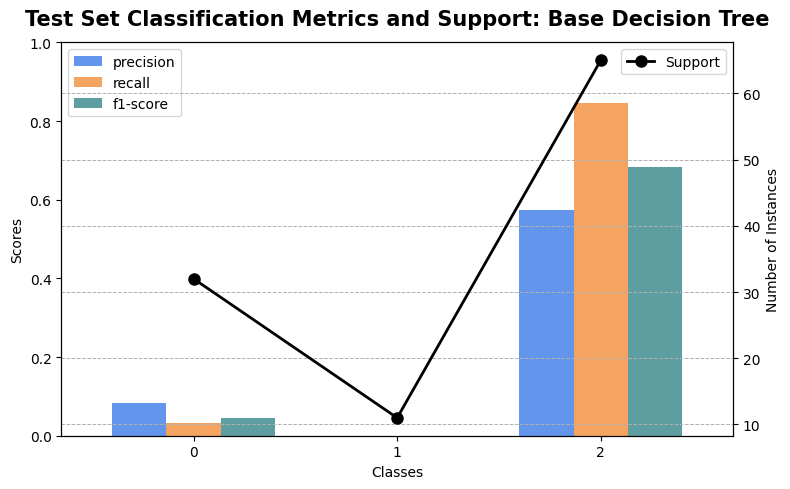

In [726]:
# Split the data into a training set (70%) and a test set (30%)
X_train, X_test, y_train, y_test = train_test_split(X_dt, y, test_size= 0.3, random_state= 42)

# Initialize the DecisionTreeClassifier
dt_classifier = DecisionTreeClassifier(random_state= 42, max_depth= 3, min_samples_leaf= 3, min_samples_split= 2)

# Train the classifier on the training data
dt_classifier.fit(X_train, y_train)

# Predict on the test data
y_pred = dt_classifier.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division= 0))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("Accuracy Score:")
print(accuracy_score(y_test, y_pred))

# Generate the confusion matrix and classification report
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, zero_division= 0, output_dict=True)

plot_confusion_matrix(cm= cm, class_labels= [0, 1, 2], title=  'Test Set Confusion Matrix: Base Decision Tree')
plot_classification_report(report= report, title=  'Test Set Classification Metrics and Support: Base Decision Tree')

#### Random Forest Model (basic)

Optimal Number of Features: 20
Optimal Features:
z_receiving_yards_cfb
z_receptions_cfb
z_touchdowns_cfb
z_avg_yards_rec_cfb
cfb_composite_score
overall
round
pre_draft_grade
z_pre_draft_position_ranking
z_pre_draft_ranking
overall_round
overall_ranking
weight_bin_average
yards_td
rec_td
round_cubed
overall_sqaured
overall_cubed
grade_height_interaction
grade_weight_interaction


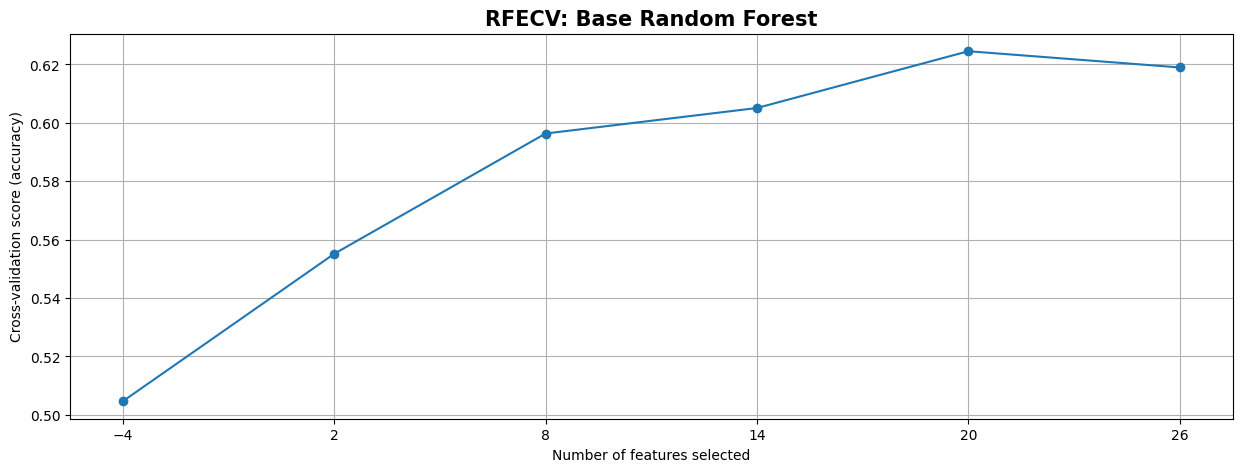

In [727]:
# DETERMINE THE BEST FEATURES TO USE IN A RANDOM FOREST ENSEMBLE MODEL

# Create and fit RFECV for a random forest
rf_classifier = RandomForestClassifier(random_state= 42)
rfecv_rf = RFECV(estimator= rf_classifier, step= 6, cv= StratifiedKFold(10), scoring= 'accuracy') # Use step size of 6 to better tune features
rfecv_rf.fit(X, y)

# Analyze RFECV recommendations
print("Optimal Number of Features:", rfecv_rf.n_features_)
print("Optimal Features:")

# Assign optimal features to X for random forest
rf_optimal_features = X.columns[rfecv_rf.support_].tolist()
X_rf = X[rf_optimal_features]

# Print optimal features
for feature in rf_optimal_features:
    print(feature)

# Plot RFECV features
plot_rfecv_results(rfecv_rf, X, 'RFECV: Base Random Forest')

In [728]:
# DETERMINE THE BEST PARAMETERS TO USE IN A RANDOM FOREST ENSEMBLE MODEL

# Define a set of parameters to test
param_grid = {
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': [2, 4, 5],
    'min_samples_leaf': [2, 3, 4],
}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state= 42), param_grid= param_grid, cv= 5, n_jobs= -1, scoring= 'accuracy')

# Fit the object to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:")
print(best_params)

print("Best Score:")
print(best_score)

# Train a new classifier using the best parameters found
best_classifier = RandomForestClassifier(**best_params, random_state= 42)
best_classifier.fit(X_train, y_train)

# Predict on the test data using the best classifier
y_pred_best = best_classifier.predict(X_test)

# Evaluate the new model
print("Improved Classification Report:")
print(classification_report(y_test, y_pred_best, zero_division= 0))

Best Parameters:
{'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2}
Best Score:
0.6263673469387755
Improved Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.19      0.25        32
           1       0.00      0.00      0.00        11
           2       0.65      0.92      0.76        65

    accuracy                           0.61       108
   macro avg       0.34      0.37      0.34       108
weighted avg       0.50      0.61      0.53       108



Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.22      0.28        32
           1       0.00      0.00      0.00        11
           2       0.66      0.91      0.76        65

    accuracy                           0.61       108
   macro avg       0.35      0.38      0.35       108
weighted avg       0.51      0.61      0.54       108

Random Forest Confusion Matrix:
[[ 7  0 25]
 [ 5  0  6]
 [ 6  0 59]]
Random Forest Accuracy Score:
0.6111111111111112


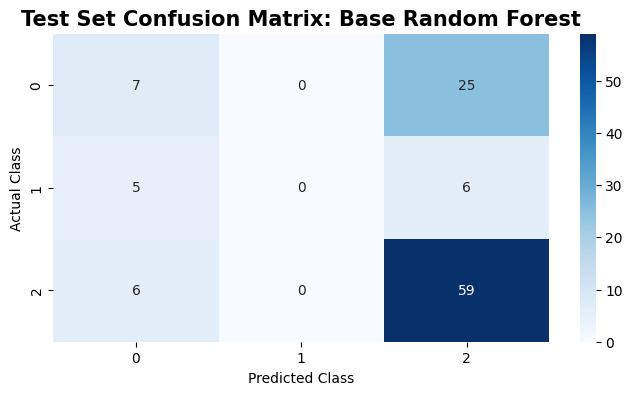

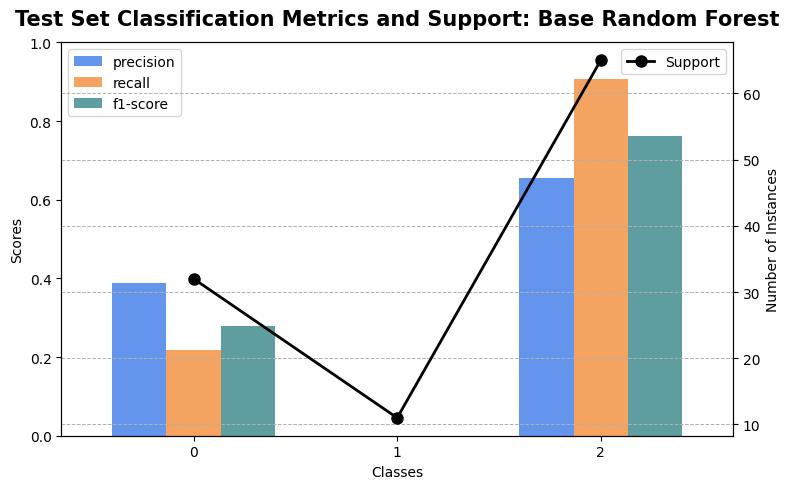

In [729]:
# Initialize random forest
rf_classifier = RandomForestClassifier(random_state= 42, max_depth= 3, min_samples_leaf= 4, min_samples_split= 2)

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X_rf, y, test_size= 0.3, random_state= 42)

# Train the classifier on the training data
rf_classifier.fit(X_train, y_train)

# Predict on the test data
y_pred_rf = rf_classifier.predict(X_test)

# Evaluate the model
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, zero_division= 0))

print("Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

print("Random Forest Accuracy Score:")
print(accuracy_score(y_test, y_pred_rf))

# Generate the confusion matrix and classification report
cm = confusion_matrix(y_test, y_pred_rf)
report = classification_report(y_test, y_pred_rf, zero_division= 0, output_dict= True)

plot_confusion_matrix(cm= cm, class_labels= [0, 1, 2], title=  'Test Set Confusion Matrix: Base Random Forest')
plot_classification_report(report= report, title=  'Test Set Classification Metrics and Support: Base Random Forest')

#### Class Imbalance Analysis

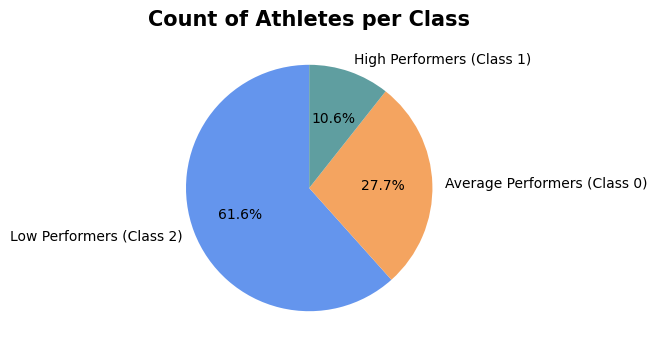

In [730]:
# CHART CLASS IMBALANCE NUMERICALLY

# Assign wedge labels and amounts
labels = ['Low Performers (Class 2)', 'Average Performers (Class 0)', 'High Performers (Class 1)']
amounts = [
    len(df_aggregated[df_aggregated['cluster']== 2]), len(df_aggregated[df_aggregated['cluster']== 0]), len(df_aggregated[df_aggregated['cluster']== 1])
]

# Prepare wedge colors
colors= ['cornflowerblue', 'sandybrown', 'cadetblue']

# Prepare the figure
fig, ax = plt.subplots(figsize= (8, 4))

# Create the pie chart
ax.pie(amounts, labels = labels, autopct= '%1.1f%%', startangle= 90, colors= colors)
ax.set_title('Count of Athletes per Class', fontweight= 'bold', fontsize= 15)

# Show the plot
plt.show()


#### Apply SMOTE to Data

In [731]:
# Split the data into a training set (70%) and a test set (30%)
X_dt = df_aggregated.dropna()[dt_optimal_features]
y_dt = df_aggregated.dropna()['cluster']  # Make sure this is correct
X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(X_dt, y_dt, test_size= 0.3, random_state= 42, stratify= y_dt)

# Initialize SMOTE and apply it to the training data (Decision Tree)
smote = SMOTE(random_state=42)
X_train_smote_dt, y_train_smote_dt = smote.fit_resample(X_train_dt, y_train_dt)


# Split the data into a training set (70%) and a test set (30%)
X_rf = df_aggregated.dropna()[rf_optimal_features]
y_rf = df_aggregated.dropna()['cluster']  # Make sure this is correct
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size= 0.3, random_state= 42, stratify= y_rf)

# Initialize SMOTE and apply it to the training data (Random Forest)
smote = SMOTE(random_state=42)
X_train_smote_rf, y_train_smote_rf = smote.fit_resample(X_train_rf, y_train_rf)

#### Decision Tree (SMOTE)

In [732]:
# DETERMINE THE BEST PARAMETERS TO USE IN A SMOTE DECISION TREE MODEL

# Define the parameter grid
param_grid = {
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': [2, 4, 5],
    'min_samples_leaf': [2, 3, 4]
}

# Initialize the grid search model
grid_search = GridSearchCV(estimator= DecisionTreeClassifier(random_state= 42), param_grid= param_grid, cv= 5, n_jobs= -1, scoring= 'accuracy')

# Fit the grid search to the data
grid_search.fit(X_train_smote_dt, y_train_smote_dt)

# Print the best parameters and the best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best Score: 0.6739215686274511


Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.39      0.41        28
           1       0.20      0.27      0.23        11
           2       0.71      0.69      0.70        61

    accuracy                           0.56       100
   macro avg       0.44      0.45      0.45       100
weighted avg       0.57      0.56      0.57       100

Confusion Matrix:
[[11  5 12]
 [ 3  3  5]
 [12  7 42]]
Accuracy Score:
0.56


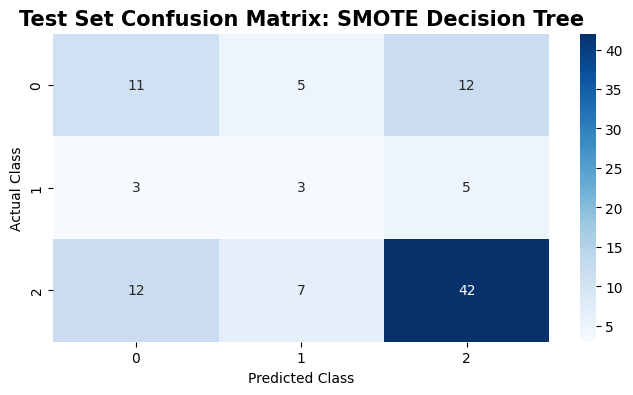

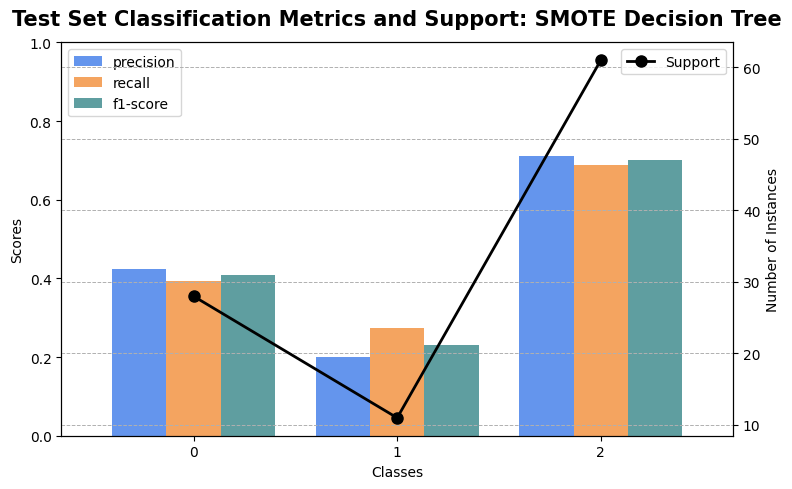

In [733]:
# GENERATE A SMOTE DECISION TREE MODEL

# Initialize the DecisionTreeClassifier
dt_classifier = DecisionTreeClassifier(random_state= 42, max_depth= 9, min_samples_leaf= 3, min_samples_split= 5)

# Train the classifier on the SMOTE-augmented training data
dt_classifier.fit(X_train_smote_dt, y_train_smote_dt)

# Predict on the test data
y_pred = dt_classifier.predict(X_test_dt)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test_dt, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test_dt, y_pred))

print("Accuracy Score:")
print(accuracy_score(y_test_dt, y_pred))

# Generate the confusion matrix and classification report
cm = confusion_matrix(y_test_dt, y_pred)
report = classification_report(y_test_dt, y_pred, output_dict= True)

plot_confusion_matrix(cm= cm, class_labels= [0, 1, 2], title=  'Test Set Confusion Matrix: SMOTE Decision Tree')
plot_classification_report(report= report, title=  'Test Set Classification Metrics and Support: SMOTE Decision Tree')


#### Random Forest (SMOTE)

In [734]:
# DETERMINE THE BEST PARAMETERS TO USE IN A SMOTE RANDOM FOREST ENSEMBLE MODEL

# Stratified K-Fold to maintain class distribution
skf = StratifiedKFold(n_splits= 5, shuffle= True, random_state= 42)

param_grid = {
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [2, 3, 4],
    'class_weight': ['balanced', 'balanced_subsample']
}

# Initialize the grid search model with f1_weighted scoring
grid_search = GridSearchCV(estimator= RandomForestClassifier(random_state= 42),param_grid= param_grid, cv= skf, n_jobs= -1, scoring= 'f1_weighted')

# Fit the grid search to the data
grid_search.fit(X_train_smote_rf, y_train_smote_rf)

# Print the best parameters and the best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'class_weight': 'balanced_subsample', 'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best Score: 0.7500879105518103


Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.50      0.48        28
           1       0.43      0.27      0.33        11
           2       0.78      0.80      0.79        61

    accuracy                           0.66       100
   macro avg       0.56      0.53      0.54       100
weighted avg       0.65      0.66      0.65       100

Confusion Matrix:
[[14  3 11]
 [ 5  3  3]
 [11  1 49]]
Accuracy Score:
0.66


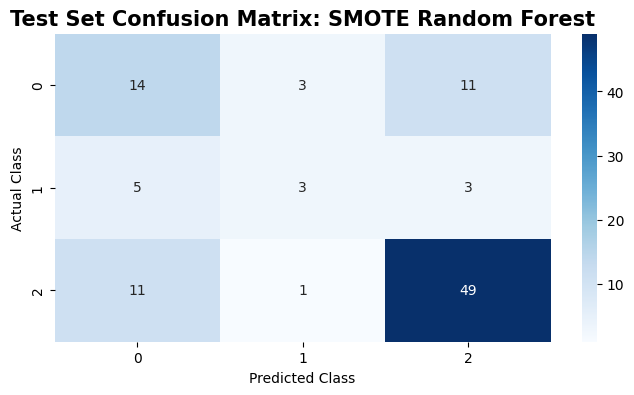

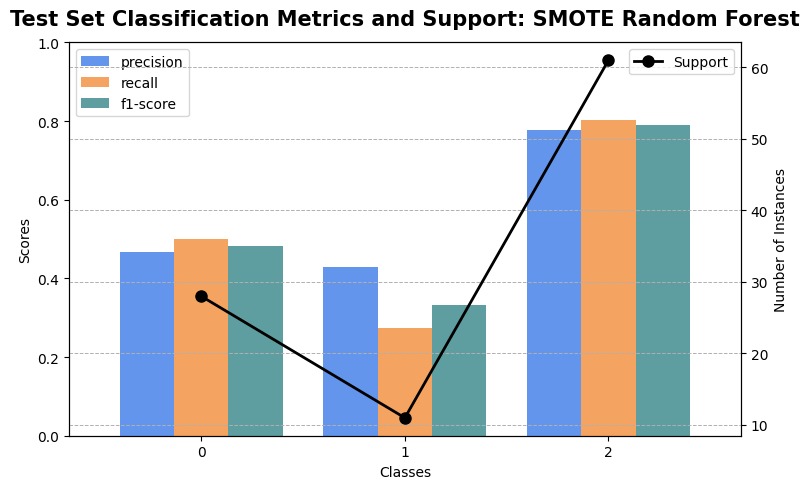

In [735]:
# Initialize the DecisionTreeClassifier
rf_classifier = RandomForestClassifier(random_state= 42, class_weight='balanced_subsample', max_depth= 9, min_samples_leaf= 2, min_samples_split= 2)

# Train the classifier on the SMOTE-augmented training data
rf_classifier.fit(X_train_smote_rf, y_train_smote_rf)

# Predict on the test data
y_pred = rf_classifier.predict(X_test_rf)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test_rf, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test_rf, y_pred))

print("Accuracy Score:")
print(accuracy_score(y_test_rf, y_pred))

# Generate the confusion matrix and classification report
cm = confusion_matrix(y_test_rf, y_pred)
report = classification_report(y_test_rf, y_pred, output_dict= True)

plot_confusion_matrix(cm= cm, class_labels= [0, 1, 2], title=  'Test Set Confusion Matrix: SMOTE Random Forest')
plot_classification_report(report= report, title=  'Test Set Classification Metrics and Support: SMOTE Random Forest')